In [1]:
!pip install monai thop pydicom
# !pip install gdcm pylibjpeg pylibjpeg-libjpeg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.3 MB/s eta 0:00:00


In [2]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

2024-04-04 11:58:00.890620: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 11:58:00.890743: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 11:58:01.024120: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

print_config()

2024-04-04 11:58:40.560559: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 11:58:40.560618: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 11:58:40.561985: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


MONAI version: 1.3.0
Numpy version: 1.26.4
Pytorch version: 2.1.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /opt/conda/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.13
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.12.0
Pillow version: 9.5.0
Tensorboard version: 2.15.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.16.2
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.3
pandas version: 2.2.1
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.38.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://do

In [4]:
import pandas as pd
import pydicom
from torchvision import transforms
import pickle
import cv2

from sklearn.model_selection import train_test_split

# Timing utility
from timeit import default_timer as timer
from tqdm import tqdm

import torch
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)


print("all imported")

set_determinism(seed=0)

all imported


In [5]:
diseases = ['Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly',
 'Consolidation', 'ILD', 'Infiltration', 'Lung Opacity', 'Nodule/Mass',
 'Other lesion', 'Pleural effusion', 'Pleural thickening', 'Pneumothorax',
 'Pulmonary fibrosis']

# decided on the basis of frequency of occurence of individual diseases in images.

# Drop columns not in the list
columns_to_keep = diseases.copy()
columns_to_keep.append('image_id')

print(diseases)
print(columns_to_keep)

['Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly', 'Consolidation', 'ILD', 'Infiltration', 'Lung Opacity', 'Nodule/Mass', 'Other lesion', 'Pleural effusion', 'Pleural thickening', 'Pneumothorax', 'Pulmonary fibrosis']
['Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly', 'Consolidation', 'ILD', 'Infiltration', 'Lung Opacity', 'Nodule/Mass', 'Other lesion', 'Pleural effusion', 'Pleural thickening', 'Pneumothorax', 'Pulmonary fibrosis', 'image_id']


In [6]:
# some helper functions:-

def delete_columns(df, columns_to_keep=columns_to_keep, root_folder='/train'):
    columns_to_drop = [col for col in df.columns if col not in columns_to_keep]
    print("COLUMNS to drop:", columns_to_drop)
    df.drop(columns=columns_to_drop, inplace=True)
    print(f"Deleted columns from {root_folder.split('/')[-1]} folder")
    return df

def remove_all_zeros(df, diseases=diseases, root_folder='/train'):
    # Remove rows where all values are 0 in the disease labels
    df = df[(df[diseases] != 0).any(axis=1)]
    df.reset_index(drop=True, inplace=True)
    return df

def add_file_path_column(df, root_folder='/train'):
    df['file_path'] = df['image_id'].apply(lambda x: os.path.join(root_folder, f"{x}.npy")) # adjust dicom or png
    print(f"Added file_path column to {root_folder.split('/')[-1]} folder")
    return df



In [7]:
import pandas as pd

# Load the original CSV file
train_data = pd.read_csv("/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train.csv")


# Extract unique pairs of class_id and class_name
class_mapping = train_data[['class_id', 'class_name']].drop_duplicates()

# Sort the mapping by class_id
class_mapping = class_mapping.sort_values(by='class_id')

# Display the sorted mapping without the index
print(class_mapping.to_string(index=False))

disease_labels = class_mapping['class_name'].values
print("Disease LABELS :", disease_labels)
print('-'*100)

print("Now converting into one hot vector format")
### Convert the csv into image_id -> 0,0,0, ..... 1., 0, 1 (15 labels format)

# Convert class_id to string to enable one-hot encoding
train_data['class_id'] = train_data['class_id'].astype(str)

# Perform one-hot encoding to convert class IDs into binary columns
one_hot_encoded = pd.get_dummies(train_data['class_id'])

# Convert boolean values to integers (0 for False, 1 for True)
one_hot_encoded = one_hot_encoded.astype(int)

# Concatenate one-hot encoded columns with original DataFrame
train_data = pd.concat([train_data, one_hot_encoded], axis=1)
# print(train_data.columns)

# Group by image ID and aggregate the one-hot encoded class columns for each class separately
train_data = train_data.groupby('image_id').agg({
#     'width': 'first',
#     'height': 'first',
    '0': 'max', '1': 'max', '2': 'max', '3': 'max', '4': 'max',
    '5': 'max', '6': 'max', '7': 'max', '8': 'max', '9': 'max',
    '10': 'max', '11': 'max', '12': 'max', '13': 'max', '14': 'max'
}).reset_index()



print("UNIQUE images IN THE DATASET:", len(train_data.image_id.unique()))
print("num rows in dataset  :", len(train_data))
# train_data.head()

# Count occurrences of each class
class_counts = train_data.iloc[:, 1:].sum()
print("TOTAL Individual class counts:-\n", class_counts)
print('-'*100)


# the 14 th class is no finding...


# Save the new DataFrame to a new CSV file
# train_data.to_csv("one_hot_vector_data.csv", index=False)


# Check if 'no-finding' class is marked while any other abnormality class is also marked
# for index, row in train_data.iterrows():
#     if row['14'] == 1 and row.iloc[1:].sum() > 1:
#         print("Issue found in row:", index)
#         print("Other abnormality classes also marked in this row.")



# Rename the one-hot encoded columns
train_data = train_data.rename(columns=dict(zip(train_data.columns[1:], disease_labels)))
print("Renamed the columns from numbers to disease_label names")


### Removing the 'no finding label' ###
train_data = delete_columns(train_data, columns_to_keep=columns_to_keep, root_folder='train')
train_data = remove_all_zeros(train_data, diseases=diseases, root_folder='train')



## Adding file_path column
train_data = add_file_path_column(train_data, root_folder='/kaggle/input/vinbigdata-512-voi-clahe/vinbigdata-512-resized-clahe2-8,8_train')

# Split 10% of the training data as validation data, with random_state=42, for reproducibility
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(val_data, test_size=0.5,random_state=42)


# reducing the size (comment this)
# train_data = train_data.head(500)
# val_data = val_data.head(500)
# test_data = test_data.head(500)

# Resetting the index, very important
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

### ADJUST diseases & disease_labels ###
# collecting & storing the labels separately

#adjust diseases or disease_labels
train_paths = train_data['file_path'].values
train_labels = train_data[diseases].values

val_paths = val_data['file_path'].values
val_labels = val_data[diseases].values

test_paths = test_data['file_path'].values
test_labels = test_data[diseases].values



print("length of train:", len(train_data), len(train_paths), len(train_labels))
print("length of val:", len(val_data), len(val_data), len(val_data))
print("length of test:", len(test_data), len(test_data), len(test_data))


print("Unique image_ids in train:", len(train_data['image_id'].unique()))
print("Unique image_ids in val:", len(val_data['image_id'].unique()))
print("Unique image_ids in test:", len(test_data['image_id'].unique()))

# train_data.info() except image_id all the other columns are of int datatype



 class_id         class_name
        0 Aortic enlargement
        1        Atelectasis
        2      Calcification
        3       Cardiomegaly
        4      Consolidation
        5                ILD
        6       Infiltration
        7       Lung Opacity
        8        Nodule/Mass
        9       Other lesion
       10   Pleural effusion
       11 Pleural thickening
       12       Pneumothorax
       13 Pulmonary fibrosis
       14         No finding
Disease LABELS : ['Aortic enlargement' 'Atelectasis' 'Calcification' 'Cardiomegaly'
 'Consolidation' 'ILD' 'Infiltration' 'Lung Opacity' 'Nodule/Mass'
 'Other lesion' 'Pleural effusion' 'Pleural thickening' 'Pneumothorax'
 'Pulmonary fibrosis' 'No finding']
----------------------------------------------------------------------------------------------------
Now converting into one hot vector format
UNIQUE images IN THE DATASET: 15000
num rows in dataset  : 15000
TOTAL Individual class counts:-
 0      3067
1       186
2       452
3

In [8]:
# Count occurrences of each class
class_counts = train_data.iloc[:, 1:-1].sum()
print("TRAIN Individual class counts:-\n", class_counts)

# Count occurrences of each class
class_counts = val_data.iloc[:, 1:-1].sum()
print("VAL Individual class counts:-\n", class_counts)

# Count occurrences of each class
class_counts = test_data.iloc[:, 1:-1].sum()
print("TEST Individual class counts:-\n", class_counts)

TRAIN Individual class counts:-
 Aortic enlargement    2464
Atelectasis            151
Calcification          348
Cardiomegaly          1852
Consolidation          274
ILD                    308
Infiltration           481
Lung Opacity          1039
Nodule/Mass            678
Other lesion           900
Pleural effusion       796
Pleural thickening    1574
Pneumothorax            75
Pulmonary fibrosis    1272
dtype: int64
VAL Individual class counts:-
 Aortic enlargement    301
Atelectasis            16
Calcification          47
Cardiomegaly          238
Consolidation          45
ILD                    38
Infiltration           64
Lung Opacity          141
Nodule/Mass            79
Other lesion          112
Pleural effusion      128
Pleural thickening    204
Pneumothorax            9
Pulmonary fibrosis    162
dtype: int64
TEST Individual class counts:-
 Aortic enlargement    302
Atelectasis            19
Calcification          57
Cardiomegaly          210
Consolidation          34
ILD   

In [9]:
train_data.head()

,image_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,file_path
0,c5c36ce7f8adbd045bfe59a325eeae47,1,0,0,1,0,0,0,0,0,0,0,0,0,0,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
1,f62a549cbf9dedb3a5990a691bd7c27a,1,0,1,0,0,0,0,0,1,1,0,0,0,1,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
2,fbc1bf59ac6832df4802bd8a473d26f4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
3,1f80202df9f9ee45002ea22f2f29d31f,1,0,1,1,0,0,0,0,0,1,0,0,0,1,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
4,3b37f8d28d0153cedc41acb8020a0a6f,1,0,0,1,0,0,0,1,0,0,0,0,0,0,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...


In [10]:
val_data.head()

,image_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,file_path
0,ccff375f4139cef65b98385224cfc810,1,0,0,0,0,0,0,0,0,1,0,0,0,0,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
1,db1942c4b69ecc90ff870f987b7c5284,1,0,1,1,0,0,0,0,0,0,0,0,0,0,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
2,fc50039c45fdb6c9224bfff5ba4e64b3,0,0,0,0,1,1,1,1,1,0,0,1,0,1,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
3,14629917f69e21145d1e662ef6c0dc2e,1,0,0,0,0,0,0,0,0,0,0,0,0,0,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
4,5d5a37ba110538a40cbc037126af47d3,1,0,1,0,0,1,0,1,0,1,0,1,0,1,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...


In [11]:
test_data.head()

,image_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,file_path
0,caf1b7af2b0caf57a7ae5d23b5dd2aba,0,0,0,0,0,0,1,1,0,0,1,0,0,0,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
1,e531672ae6083e717cbe83d7fc71ddda,1,0,0,1,0,0,0,0,1,1,0,0,0,0,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
2,14742737297b34ac440a0338877663ac,1,0,0,1,0,0,0,0,1,1,0,1,0,0,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
3,1912296cce436028085697480121b4eb,1,0,0,1,0,0,0,0,0,0,0,0,0,0,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
4,8bc2410a31ef52ddb3e2d41cbe1ea7ff,1,0,0,1,0,0,0,0,0,0,0,0,0,0,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...


### Visualising the images

In [12]:
train_image_files = [
    os.path.join('/', train_paths[i]) for i in range(len(train_paths))
]
print(len(train_image_files))

val_image_files = [
    os.path.join('/', val_paths[i]) for i in range(len(val_paths))
]
print(len(val_image_files))

test_image_files = [
    os.path.join('/', test_paths[i]) for i in range(len(test_paths))
]
print(len(test_image_files))

3515
439
440


In [13]:
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import matplotlib.pyplot as plt
%matplotlib inline


def read_xray(path, voi_lut = True, fix_monochrome = True, apply_clahe=True, clipLimit=2.0, tileGridSize=(8,8)):
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
#     data = data.astype(np.float32)
#     data = (data * 255.0).astype(np.float32) # no need for this I think 

    if apply_clahe:
        data = apply_clahe_to_image(data, clipLimit=clipLimit, tileGridSize=tileGridSize)
        
    return data



def apply_clahe_to_image(image, clipLimit=2.0, tileGridSize=(8,8)):
    # Convert image to uint16
    image = (image * 65535).astype(np.uint16)
    
    # Create a CLAHE object
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    
    # Apply CLAHE
    clahe_image = clahe.apply(image)
    
    # Convert image back to float32 in range [0, 1]
    clahe_image = clahe_image.astype(np.float32) / 65535.0
    
    return clahe_image



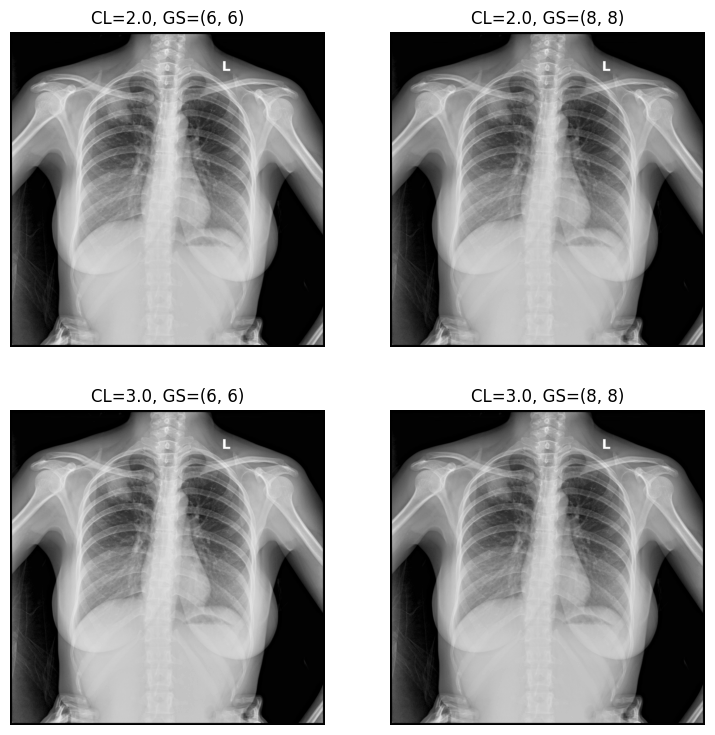

In [14]:
def plot_images(images, titles, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(9, 9))
    for i, (image, title) in enumerate(zip(images, titles)):
        ax = axes[i // cols, i % cols]
        ax.imshow(image, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.show()


path = '/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train/0005e8e3701dfb1dd93d53e2ff537b6e.dicom'
# path = '/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train/0007d316f756b3fa0baea2ff514ce945.dicom'
# path = '/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train/003cfe5ce5c0ec5163138eb3b740e328.dicom'
# path = '/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train/0076d6a1e3139927fd62459c54276c3c.dicom'
# path = '/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train/0101ad90f31ddb8fb24e9935a3dac9db.dicom'


clipLimits = [2.0, 3.0]
tileGridSizes = [(6,6),(8,8)]
images = []
titles = []


for clipLimit in clipLimits:
    for tileSize in tileGridSizes:
        images.append(read_xray(path, clipLimit=clipLimit, tileGridSize=tileSize))
        titles.append(f"clipLimit={clipLimit}, tileGridSize={tileSize}")
    
titles = [f"CL={clipLimit}, GS={tileSize}" for clipLimit in clipLimits for tileSize in tileGridSizes]
plot_images(images, titles, len(clipLimits), len(tileGridSizes))

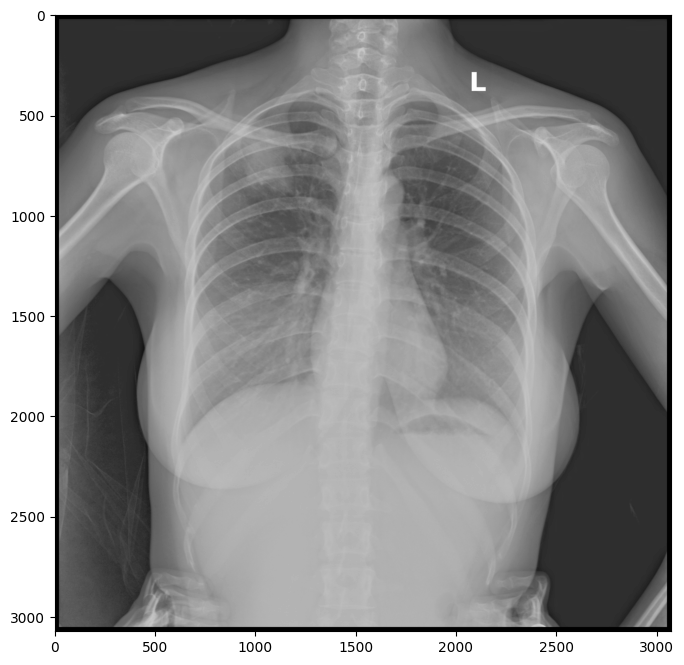

In [15]:
img = read_xray(path, voi_lut=False, apply_clahe=False)
plt.figure(figsize = (8,8))
# plt.imshow(img, cmap='bone')
plt.imshow(img, cmap='gray')

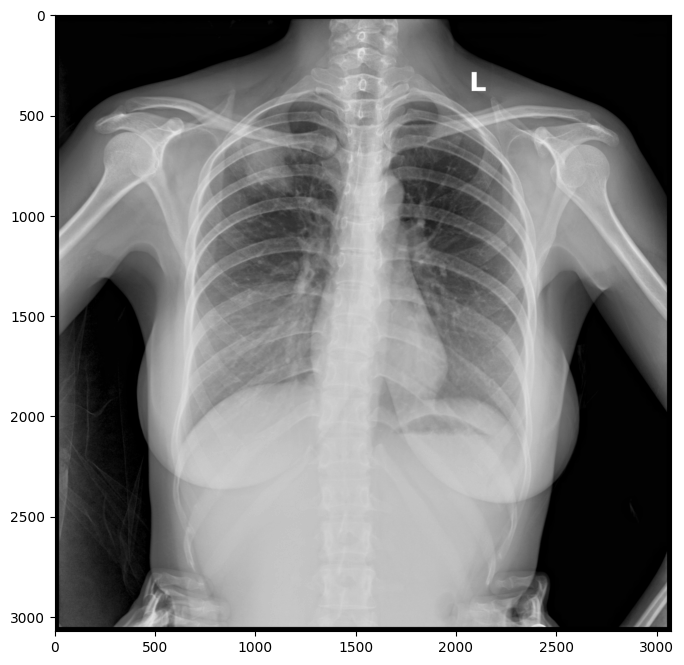

In [16]:
img = read_xray(path, voi_lut=True, apply_clahe=False)
plt.figure(figsize = (8,8))
# plt.imshow(img, cmap='bone')
plt.imshow(img, cmap='gray')

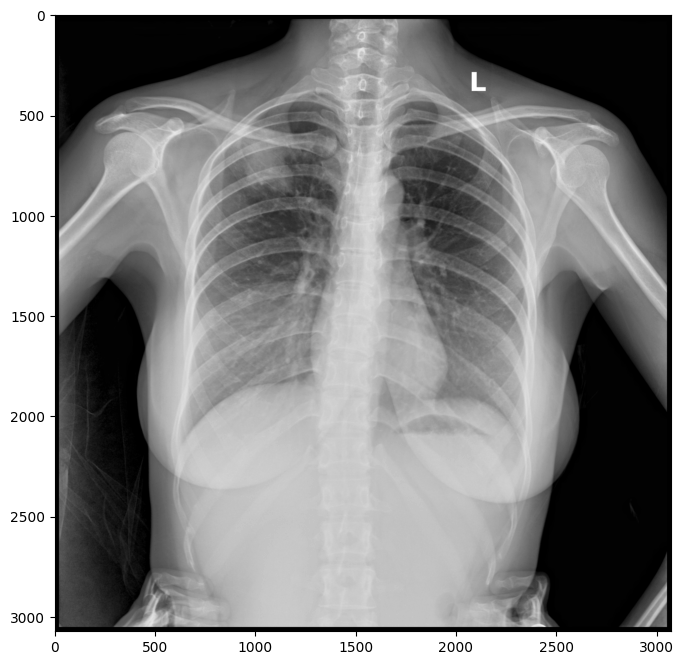

In [17]:
# the best configuration
img = read_xray(path, apply_clahe=True, clipLimit=2.0, tileGridSize=(8,8))
plt.figure(figsize = (8,8))
# plt.imshow(img, cmap='bone')
plt.imshow(img, cmap='gray')

#### The preprocessed saved images:-

image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)


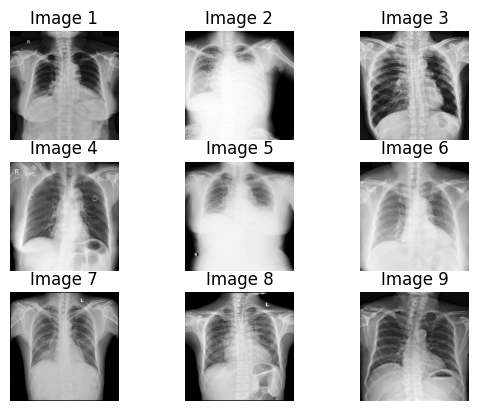

In [18]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Assuming train_image_files is a list of DICOM file paths
# Example:
# train_image_files = ["path/to/dicom/file1.dcm", "path/to/dicom/file2.dcm", ...]

for i, k in enumerate(np.random.randint(len(train_image_files), size=9)):


#     print("Image path", train_image_files[k])
    img_mat = np.load(train_image_files[k])

#     img_mat = cv2.imread(train_image_files[k])
# #     img_mat = cv2.resize(img_mat, (224, 224))
#     img_black = cv2.cvtColor(img_mat, cv2.COLOR_BGR2GRAY)
    float64_image_array = img_mat.astype(np.float64)

    
    print("image_shape:", img_mat.shape)
    
    # Visualization using Matplotlib
    plt.subplot(3, 3, i + 1)
    plt.imshow(float64_image_array, cmap='gray')  # Assuming grayscale DICOM images
    plt.title(f"Image {i + 1}")
    plt.axis('off')

plt.show()


In [19]:
BATCH_SIZE = 8
IMAGE_SIZE = (224,224) # the size to which the image would be resized before passing to the model
# num_classes = len(diseases)
num_classes = len(train_data.columns) - 2 
## ADJUST num_classes accordingly 

print("BATCH_SIZE: ", BATCH_SIZE) 
print("IMAGE_SIZE: ", IMAGE_SIZE) 
print("num_classes: ", num_classes) 

BATCH_SIZE:  8
IMAGE_SIZE:  (224, 224)
num_classes:  14


In [20]:
from monai.transforms import Compose, Lambda, EnsureChannelFirst, ScaleIntensity,\
 RandRotate, RandFlip, RandZoom, RandSpatialCrop, RandRotate90, ResizeWithPadOrCrop, Resize

def load_tensor(data):
    # Convert the data to a supported data type (e.g., float32)
    return data.astype(np.float32)


train_transforms = Compose(
    [
#         LoadImage(image_only=True), 
        Lambda(load_tensor),
        EnsureChannelFirst(channel_dim=0),
#         RandSpatialCrop(IMAGE_SIZE[0],IMAGE_SIZE[1]), random_size=False), # crops randomly ; loss of information
        Resize(spatial_size=(IMAGE_SIZE[0],IMAGE_SIZE[1])),
#         ResizeWithPadOrCrop(spatial_size=IMAGE_SIZE), # this will centrally crop : loss of information
#         RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        ScaleIntensity(),
#         RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
#         RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose(
    [
#         LoadImage(image_only=True),
        Lambda(load_tensor),
        EnsureChannelFirst(channel_dim=0),
#         ResizeWithPadOrCrop(spatial_size=IMAGE_SIZE), # this will centrally crop : loss of information
        Resize(spatial_size=(IMAGE_SIZE[0],IMAGE_SIZE[1])),

        ScaleIntensity(),

    ]
)

# y_pred_trans = Compose([Activations(softmax=True)])
# y_trans = Compose([AsDiscrete(to_onehot=num_class)])

y_pred_trans = Compose([Activations(sigmoid=True)]) # for multi-label classfication
y_trans = Compose([AsDiscrete(threshold_values=True)])


In [21]:
class VINDR_BigData_Dataset(torch.utils.data.Dataset):
    def __init__(self, paths, labels, in_chans=1, transforms=None):
        self.paths = paths
        self.labels = labels
        self.transforms = transforms
        self.target_size = IMAGE_SIZE
        self.in_chans = in_chans
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
#         print(index)
        img_path = self.paths[index]
#         print(img_path, index)
        labels = self.labels[index]
#         image = read_xray(img_path, voi_lut=False, fix_monochrome=False, normalize=False)
        
#         img_mat = cv2.imread(img_path)
#         img_black = cv2.cvtColor(img_mat, cv2.COLOR_BGR2GRAY)
        
        image = np.load(img_path)
        
        # Expand the dimensions to add a channel dimension
        image = np.expand_dims(image, axis=0)
        
        if self.transforms:
            image = self.transforms(image)
        
        return image, labels


train_ds = VINDR_BigData_Dataset(train_paths, train_labels, in_chans=1, transforms=train_transforms)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

val_ds = VINDR_BigData_Dataset(val_paths, val_labels, in_chans=1, transforms=val_transforms)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=4)

test_ds = VINDR_BigData_Dataset(test_paths, test_labels, in_chans=1, transforms=val_transforms)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=4)

print("No. of TRAIN batches:", len(train_loader))
print("No. of VAL batches:", len(val_loader))
print("No. of TEST batches:", len(test_loader))


No. of TRAIN batches: 440
No. of VAL batches: 55
No. of TEST batches: 55


In [22]:
from thop import profile
from thop import clever_format
import torch

def display_params_flops(model):
    #params
    num_params = sum(p.numel() for p in model.parameters())
    num_params_millions = num_params / 1e6
    print(f"Number of parameters in millions: {num_params_millions:.2f} M")

    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    num_params_millions = num_params / 1e6
    print(f"Number of trainable parameters in millions: {num_params_millions:.2f} M")


    #FLOPS
    input_size = (1, 1, IMAGE_SIZE[0], IMAGE_SIZE[1])  


    # Move the model to GPU if available
    if torch.cuda.is_available():
        model = model.cuda()

    # Use thop.profile to count FLOPs
    input_tensor = torch.randn(*input_size)
    if torch.cuda.is_available():
        input_tensor = input_tensor.cuda()
    flops, params = profile(model, inputs=(input_tensor,))

    # Convert FLOPs to gigaFLOPs and format the results
    flops, params = clever_format([flops, params], "%.2f")
    print(f"FLOPs: {flops}, Params: {params}")
    

### Model Definition

In [23]:
import torch
import torch.nn as nn
import torchvision.models as models

from torch import nn
from timm import create_model

class DenseNetModel(nn.Module):
    def __init__(self, num_classes, pretrained=True, fine_tune=False):
        super(DenseNetModel, self).__init__()
        self.densenet = create_model(
            'densenet121.tv_in1k', 
            pretrained=pretrained,
            num_classes=num_classes,
            in_chans=1
        )

        if not fine_tune:
            for param in self.densenet.parameters():
                param.requires_grad = False
            
            for param in self.densenet.global_pool.parameters():
                param.requires_grad = True
                
            for param in self.densenet.head_drop.parameters():
                param.requires_grad = True
                
            for param in self.densenet.classifier.parameters():
                param.requires_grad = True
        
        
    def forward(self, x):
        x = self.densenet(x)
        return x
    
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNetModel(num_classes, fine_tune=False)
model.to(device)

# print(model)
print()

x = torch.randn(1, 1, IMAGE_SIZE[0], IMAGE_SIZE[1]).to(device)


output = model(x)
print("Model output's shape:", output.shape)
print(output) # logits 
display_params_flops(model)

model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]


Model output's shape: torch.Size([1, 14])
tensor([[-0.7864, -0.0877, -0.1493,  0.0476,  0.8378,  0.2733,  0.5630, -0.5177,
         -0.2991, -0.4272,  0.5194, -0.3404,  1.1664,  0.2937]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
Number of parameters in millions: 6.96 M
Number of trainable parameters in millions: 0.01 M
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_avgpool() for <class 'torch.nn.modules.pooling.AvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPs: 2.75G, Params: 6.88M


In [24]:
model = DenseNetModel(num_classes, fine_tune=False) # change fine_tune as required
model.to(device)


loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), 3e-5) # adjust learning rate 
# reduce lr during fine tuning

In [25]:
import torch
import torch.nn as nn

# Assuming your model outputs logits
logits = torch.randn(3, num_classes)  # Example logits
targets = torch.randint(0, 2, (3, num_classes))  # Example targets (binary, one-hot encoded)
print(logits)
print(targets)

# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Calculate the loss
loss = criterion(logits, targets.float())
print("loss:", loss)

tensor([[-0.3163,  1.9935, -2.0185,  0.4233, -0.8968,  0.0702, -2.4830,  0.1372,
          1.1742,  0.4089,  0.0767,  0.5952,  0.2946, -0.5926],
        [-0.5748,  0.2538,  1.5732,  0.7694, -1.5749,  0.1891,  1.0123,  0.3869,
         -0.1654, -0.5361,  1.1282, -0.2446, -1.0029, -0.8889],
        [ 1.2460, -1.7757,  2.1710,  0.0668, -1.0365, -2.2204,  0.4635,  0.7128,
         -0.3732, -0.1626,  0.4821,  2.2065, -0.4376,  0.0592]])
tensor([[1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1]])
loss: tensor(0.8505)


In [26]:
def train(model, loss_function=loss_function, optimizer=optimizer, num_epochs=20,
          ranOnce=False, epochs_ran=0, model_path='model.pth', history_path='history.csv',
         save_interval=1):
    '''
    returns the 'history' dataframe.
    
    This function trains the model for a fixed number of epochs,
    saving the checkpoints regularly.
    It monitors time taken per epoch and total time elapsed.
    It tracks loss, roc_auc, f1, accuracy, precision, recall for both train & validation data.
    It also saves the best model on loss, roc_auc, f1 and accuracy.
    '''
    
    
    initial_epoch = 0
    
    valid_loss_min = np.Inf
    valid_max_accuracy = 0
    valid_max_auc = 0
    valid_max_precision = 0
    valid_max_recall = 0
    valid_max_f1 = 0
    
    
    
    if ranOnce:
        if epochs_ran <= 0:
            print("Mention the no. of epochs run by the model already for which you have the weights")
            return 

        history = pd.read_csv(history_path)
        history=history.head(epochs_ran)
        model.load_state_dict(torch.load(model_path))
        '''
        It has the following columns:-
        epoch_number, train_loss, val_loss, train_auc, val_auc, train_accuracy, val_accuracy,
        train_f1, val_f1, train_precision, val_precision, train_recall, val_recall,
        time_current_epoch, total_time_elapsed
        '''
        initial_epoch = len(history)
        
        valid_loss_min = history['val_loss'].min()
        valid_max_accuracy = history['val_accuracy'].max()
        valid_max_auc = history['val_auc'].max()
        valid_max_precision = history['val_precision'].max()
        valid_max_recall = history['val_recall'].max()
        valid_max_f1 = history['val_f1'].max()
        
        
        print(f"Model was already trained fo {initial_epoch} epochs,\
    with minimum loss: {valid_loss_min}, max accuracy: {valid_max_accuracy},\
    max auc: {valid_max_auc}, max precision: {valid_max_precision}, \
    max recall: {valid_max_recall}, max f1: {valid_max_f1}")
        
    else:
        print("Starting afresh!")
        history = pd.DataFrame()
#         history = pd.DataFrame(columns=['epoch_number', 'train_loss', 'train_accuracy', 'train_f1',\
#             'train_precision', 'train_recall', 'train_auc', 'train_auc_scores',\
#             'val_loss', 'val_accuracy', 'val_f1', 'val_precision', 'val_recall', 'val_auc','val_auc_scores',\
#             'time_current_epoch'])
        
    # Main loop
    for epoch in range(initial_epoch+1, initial_epoch + num_epochs+1):
        
        history_list = [] # stores the history for the current epoch in a list 
        
        train_labels_all = []
        train_predictions_all = []
        train_scores_all = []
        
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
         # Set to training
        model.train()
        start = timer()
        
        # Training loop
        for batch_data in tqdm(train_loader):
            inputs, labels = batch_data[0].to(device), batch_data[1].float().to(device)  
            
            # Clear gradients
            optimizer.zero_grad()

            outputs = model(inputs)
#             print("train_batch_outputs:", outputs)
#             print("train_batch_labels:", labels)
            
            outputs = outputs.float()
            labels = labels.float()

            # Loss and backpropagation of gradients
            loss = loss_function(outputs, labels)

            loss.backward()
            optimizer.step()  # Update the parameters
            
            train_loss += loss.item()
            
            # Calculate training accuracy
            scores = torch.sigmoid(outputs)
            predictions = torch.sigmoid(outputs) > 0.5
            total_train += labels.size(0) * labels.size(1)
            
            correct_train += (predictions == labels).sum().item()
            
#             print("train_batch_predictions:", predictions)
#             print("train_batch_scores:", scores)
            
            train_scores_all.extend(scores.detach().cpu().numpy())
            train_labels_all.extend(labels.cpu().numpy())
            train_predictions_all.extend(predictions.cpu().numpy())
            
#             train_labels_all.extend(labels)
#             train_predictions_all.extend(predictions)
            
    
        train_loss /= len(train_loader)
        accuracy_train = correct_train / total_train
        
        print(f"Current epoch {epoch}/{initial_epoch + num_epochs}")
        print(f"Training Loss: {train_loss:.4f}, Accuracy: {accuracy_train:.4f}")
        print("correct:", correct_train, " out of ", total_train)

        train_predictions_all = np.array(train_predictions_all).astype(float)
        train_labels_all = np.array(train_labels_all).astype(float)
        
#         print(classification_report(train_labels_all, train_predictions_all, target_names=diseases))
        
        cm = multilabel_confusion_matrix(train_predictions_all, train_labels_all)
        # we will use macro-averaging strategy.
        accuracy_arr = []
        precision_arr = []
        recall_arr = []
        f1_arr = []
        
        for i in range(num_classes):
#             print(cm[i])
#             print(cm[i].sum())
            
#             cfm_plot = sn.heatmap(cm[i], annot=False)
             # TP + TN / TP + TN  + FP + FN
            accuracy = (cm[i][0][0]+ cm[i][1][1])/cm[i].sum()

            # TP / TP + FP
            precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])

            # TP / TP + FN
            recall = cm[i][1][1]/(cm[i][0][1]+cm[i][1][1]) # sensitivity
            f1 = (2*precision*recall)/(precision+recall)
#             print(diseases[i],": ",round(accuracy*100,2),"%")
#             print("Precision: ",round(precision,2))
#             print("Recall:", round(recall,2))
#             print("F1-Score:", round(f1,2))
#             print('==========================================================')


            accuracy_arr.append(accuracy)
            precision_arr.append(precision)
            recall_arr.append(recall)
            f1_arr.append(f1)
        
        
        accuracy_arr = np.nan_to_num(accuracy_arr, nan=0)
        precision_arr = np.nan_to_num(precision_arr, nan=0)
        recall_arr = np.nan_to_num(recall_arr, nan=0)
        f1_arr = np.nan_to_num(f1_arr, nan=0)
        
        accuracy_macro_train = round(sum(accuracy_arr) / len(accuracy_arr), 4)
        precision_macro_train = round(sum(precision_arr) / len(precision_arr), 4)
        recall_macro_train = round(sum(recall_arr) / len(recall_arr), 4)
        f1_macro_train = round(sum(f1_arr) / len(f1_arr), 4)
        roc_auc_macro_train = round(roc_auc_score(train_labels_all, train_scores_all, average='macro'), 4)

        print("MACRO-averged metrics", end=':- ')
        print(f"accuracy: {accuracy_macro_train}, precision: {precision_macro_train}", end=', ')
        print(f"recall: {recall_macro_train}, f1: {f1_macro_train}, ROC_AUC: {roc_auc_macro_train}")

        
        #VALIDATION START:->
        val_labels_all = []
        val_predictions_all = []
        val_scores_all = []
        
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()
        
            #Validation loop
            for batch_data in tqdm(val_loader):
                inputs, labels = batch_data[0].to(device), batch_data[1].float().to(device)  

                outputs = model(inputs)
                outputs = outputs.float()
                labels = labels.float()
                
                loss = loss_function(outputs, labels)                
                val_loss += loss.item()

                scores = torch.sigmoid(outputs)
                predictions = torch.sigmoid(outputs) > 0.5
                total_val += labels.size(0) * labels.size(1)
                
                correct_val += (predictions == labels).sum().item()
                
                val_scores_all.extend(scores.detach().cpu().numpy())
                val_labels_all.extend(labels.cpu().numpy())
                val_predictions_all.extend(predictions.cpu().numpy())
                

            val_loss /= len(val_loader)
            accuracy_val = correct_val / total_val

            print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy_val:.4f}")
            print("correct:", correct_val, " out of ", total_val)

            val_predictions_all = np.array(val_predictions_all).astype(float)
            val_labels_all = np.array(val_labels_all).astype(float)

    #         print(classification_report(val_labels_all, val_predictions_all, target_names=diseases))

            cm = multilabel_confusion_matrix(val_predictions_all, val_labels_all)
            # we will use macro-averaging strategy.
            accuracy_arr = []
            precision_arr = []
            recall_arr = []
            f1_arr = []

            for i in range(num_classes):
    #             print(cm[i])
    #             print(cm[i].sum())

    #             cfm_plot = sn.heatmap(cm[i], annot=False)
#                 TP + TN / TP + TN  + FP + FN
                accuracy = (cm[i][0][0]+ cm[i][1][1])/cm[i].sum()

                # TP / TP + FP
                precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])

                # TP / TP + FN
                recall = cm[i][1][1]/(cm[i][0][1]+cm[i][1][1]) # sensitivity
                f1 = (2*precision*recall)/(precision+recall)
    #             print(diseases[i],": ",round(accuracy*100,2),"%")
    #             print("Precision: ",round(precision,2))
    #             print("Recall:", round(recall,2))
    #             print("F1-Score:", round(f1,2))
    #             print('==========================================================')

        
                accuracy_arr.append(accuracy)
                precision_arr.append(precision)
                recall_arr.append(recall)
                f1_arr.append(f1)
            
            accuracy_arr = np.nan_to_num(accuracy_arr, nan=0)
            precision_arr = np.nan_to_num(precision_arr, nan=0)
            recall_arr = np.nan_to_num(recall_arr, nan=0)
            f1_arr = np.nan_to_num(f1_arr, nan=0)
            
            accuracy_macro_val = round(sum(accuracy_arr) / len(accuracy_arr), 4)
            precision_macro_val = round(sum(precision_arr) / len(precision_arr), 4)
            recall_macro_val = round(sum(recall_arr) / len(recall_arr), 4)
            f1_macro_val = round(sum(f1_arr) / len(f1_arr), 4)
            roc_auc_macro_val = round(roc_auc_score(val_labels_all, val_scores_all, average='macro'), 4)
            
            print("MACRO-averged metrics", end=':- ')
            print(f"accuracy: {accuracy_macro_val}, precision: {precision_macro_val}", end=', ')
            print(f"recall: {recall_macro_val}, f1: {f1_macro_val}, ROC_AUC: {roc_auc_macro_val}")

            time_this_epoch = timer()-start
            print(f"Time_for_this_epoch: {(time_this_epoch):.4f} seconds")
            print("-"*120)

        
#         Add values to the history DataFrame
        history_list.append({
            'epoch_number': epoch,
            'train_loss': train_loss,
            'train_accuracy': accuracy_macro_train,
            'train_f1': f1_macro_train,
            'train_precision': precision_macro_train,
            'train_recall': recall_macro_train,
            'train_auc': roc_auc_macro_train,
            
            'val_loss': val_loss,
            'val_accuracy': accuracy_macro_val,
            'val_f1': f1_macro_val,
            'val_precision': precision_macro_val,
            'val_recall': recall_macro_val,
            'val_auc': roc_auc_macro_val,
            
            # Add other metrics as needed
            'time_current_epoch': time_this_epoch
        })
        
        # Convert the list of dictionaries to a DataFrame
        epoch_history = pd.DataFrame(history_list)

        # Concatenate the new DataFrame with the existing history DataFrame
        history = pd.concat([history, epoch_history], ignore_index=True)
        
        history.to_csv('history.csv', index=False)
#         print("history_list:", history_list)
        print('history should be saved')
        
        
#         ### HANDLING THE MODEL SAVING MECHANISM
# #       # Save the model with the best accuracy
        if accuracy_macro_val > valid_max_accuracy:
            valid_max_accuracy = accuracy_macro_val
            best_model_accuracy = model.state_dict()
            torch.save(best_model_accuracy, 'best_model_accuracy.pth')


#         # Save the model with the best AUC
        if roc_auc_macro_val > valid_max_auc:
            valid_max_auc = roc_auc_macro_val
            best_model_auc = model.state_dict()
            torch.save(best_model_auc, 'best_model_auc.pth')


#         # Save the model with the best validation loss
        if val_loss < valid_loss_min:
            valid_loss_min = val_loss
            best_model_val_loss = model.state_dict()
            torch.save(best_model_val_loss, 'best_model_val_loss.pth')
            
        # best precision
        if precision_macro_val > valid_max_precision:
            valid_max_precision = precision_macro_val
            best_model_precision = model.state_dict()
            torch.save(best_model_precision, 'best_model_precision.pth')
        
        # best recall 
        if recall_macro_val > valid_max_recall :
            valid_max_recall  = recall_macro_val
            best_model_recall = model.state_dict()
            torch.save(best_model_recall, 'best_model_recall.pth')
        
        # best f1
        if f1_macro_val > valid_max_f1 :
            valid_max_f1  = f1_macro_val
            best_model_f1 = model.state_dict()
            torch.save(best_model_f1, 'best_model_f1.pth')
            

#         # Saving model every 'save_interval' number of epochs
        if epoch % save_interval == 0:
            print(f"Saving model at epoch number: {epoch}")
            torch.save(model.state_dict(), f"model_{epoch}.pth")
        

        
    return history

In [27]:
 history = train(model, loss_function=loss_function, optimizer=optimizer, num_epochs=10,
          ranOnce=False,
         save_interval=10)

Starting afresh!


100%|██████████| 440/440 [00:31<00:00, 14.14it/s]
/tmp/ipykernel_26/3941032153.py:152: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Current epoch 1/10
Training Loss: 0.4991, Accuracy: 0.7667
correct: 37728  out of  49210
MACRO-averged metrics:- accuracy: 0.7667, precision: 0.2388, recall: 0.1641, f1: 0.1667, ROC_AUC: 0.5146


100%|██████████| 55/55 [00:03<00:00, 14.51it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4757, Accuracy: 0.7774
correct: 4778  out of  6146
MACRO-averged metrics:- accuracy: 0.7774, precision: 0.1615, recall: 0.1423, f1: 0.1296, ROC_AUC: 0.5167
Time_for_this_epoch: 34.9704 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [00:26<00:00, 16.32it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 2/10
Training Loss: 0.4583, Accuracy: 0.7878
correct: 38770  out of  49210
MACRO-averged metrics:- accuracy: 0.7878, precision: 0.2229, recall: 0.1396, f1: 0.1279, ROC_AUC: 0.5345


100%|██████████| 55/55 [00:03<00:00, 17.44it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.4699, Accuracy: 0.7808
correct: 4799  out of  6146
MACRO-averged metrics:- accuracy: 0.7808, precision: 0.1301, recall: 0.1489, f1: 0.1322, ROC_AUC: 0.5338
Time_for_this_epoch: 30.1890 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [00:27<00:00, 16.26it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 3/10
Training Loss: 0.4542, Accuracy: 0.7924
correct: 38996  out of  49210
MACRO-averged metrics:- accuracy: 0.7924, precision: 0.1932, recall: 0.1445, f1: 0.1345, ROC_AUC: 0.5552


100%|██████████| 55/55 [00:03<00:00, 17.74it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4662, Accuracy: 0.7815
correct: 4803  out of  6146
MACRO-averged metrics:- accuracy: 0.7815, precision: 0.1721, recall: 0.1478, f1: 0.1379, ROC_AUC: 0.5572
Time_for_this_epoch: 30.2263 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [00:26<00:00, 16.70it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])
/tmp/ipykernel_26/3941032153.py:152: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Current epoch 4/10
Training Loss: 0.4511, Accuracy: 0.7945
correct: 39095  out of  49210
MACRO-averged metrics:- accuracy: 0.7945, precision: 0.1777, recall: 0.1457, f1: 0.1373, ROC_AUC: 0.5726


100%|██████████| 55/55 [00:03<00:00, 17.23it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.4639, Accuracy: 0.7852
correct: 4826  out of  6146
MACRO-averged metrics:- accuracy: 0.7852, precision: 0.1343, recall: 0.1476, f1: 0.1314, ROC_AUC: 0.5706
Time_for_this_epoch: 29.6097 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [00:26<00:00, 16.63it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 5/10
Training Loss: 0.4483, Accuracy: 0.7951
correct: 39129  out of  49210
MACRO-averged metrics:- accuracy: 0.7951, precision: 0.194, recall: 0.1446, f1: 0.1353, ROC_AUC: 0.5864


100%|██████████| 55/55 [00:02<00:00, 18.51it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.4598, Accuracy: 0.7877
correct: 4841  out of  6146
MACRO-averged metrics:- accuracy: 0.7877, precision: 0.1857, recall: 0.1645, f1: 0.1521, ROC_AUC: 0.5841
Time_for_this_epoch: 29.5063 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [00:27<00:00, 16.27it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])
/tmp/ipykernel_26/3941032153.py:152: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Current epoch 6/10
Training Loss: 0.4462, Accuracy: 0.7978
correct: 39262  out of  49210
MACRO-averged metrics:- accuracy: 0.7978, precision: 0.1781, recall: 0.1486, f1: 0.142, ROC_AUC: 0.5966


100%|██████████| 55/55 [00:03<00:00, 17.69it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.4582, Accuracy: 0.7896
correct: 4853  out of  6146
MACRO-averged metrics:- accuracy: 0.7896, precision: 0.1875, recall: 0.1548, f1: 0.1469, ROC_AUC: 0.5929
Time_for_this_epoch: 30.2243 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [00:26<00:00, 16.50it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 7/10
Training Loss: 0.4440, Accuracy: 0.7987
correct: 39303  out of  49210
MACRO-averged metrics:- accuracy: 0.7987, precision: 0.1993, recall: 0.1491, f1: 0.1436, ROC_AUC: 0.6126


100%|██████████| 55/55 [00:03<00:00, 17.72it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.4562, Accuracy: 0.7906
correct: 4859  out of  6146
MACRO-averged metrics:- accuracy: 0.7906, precision: 0.187, recall: 0.1578, f1: 0.1518, ROC_AUC: 0.6032
Time_for_this_epoch: 29.8368 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [00:26<00:00, 16.33it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 8/10
Training Loss: 0.4422, Accuracy: 0.7989
correct: 39315  out of  49210
MACRO-averged metrics:- accuracy: 0.7989, precision: 0.2693, recall: 0.1479, f1: 0.1436, ROC_AUC: 0.6149


100%|██████████| 55/55 [00:03<00:00, 17.14it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.4541, Accuracy: 0.7909
correct: 4861  out of  6146
MACRO-averged metrics:- accuracy: 0.7909, precision: 0.1854, recall: 0.1575, f1: 0.1546, ROC_AUC: 0.6107
Time_for_this_epoch: 30.2194 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [00:26<00:00, 16.63it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 9/10
Training Loss: 0.4393, Accuracy: 0.8008
correct: 39407  out of  49210
MACRO-averged metrics:- accuracy: 0.8008, precision: 0.2099, recall: 0.1517, f1: 0.1499, ROC_AUC: 0.6291


100%|██████████| 55/55 [00:03<00:00, 17.35it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4514, Accuracy: 0.7927
correct: 4872  out of  6146
MACRO-averged metrics:- accuracy: 0.7927, precision: 0.2595, recall: 0.1523, f1: 0.1569, ROC_AUC: 0.626
Time_for_this_epoch: 29.6875 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [00:26<00:00, 16.58it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 10/10
Training Loss: 0.4381, Accuracy: 0.8016
correct: 39448  out of  49210
MACRO-averged metrics:- accuracy: 0.8016, precision: 0.2081, recall: 0.1526, f1: 0.1497, ROC_AUC: 0.6324


100%|██████████| 55/55 [00:03<00:00, 16.98it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4508, Accuracy: 0.7925
correct: 4871  out of  6146
MACRO-averged metrics:- accuracy: 0.7925, precision: 0.2279, recall: 0.1536, f1: 0.155, ROC_AUC: 0.6272
Time_for_this_epoch: 29.8365 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 10


### Fine Tuning ( replace the model name )

In [28]:
model = DenseNetModel(num_classes, fine_tune=True) # change fine_tune as required
model.to(device)


loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), 7e-6) # adjust learning rate 
# reduce lr during fine tuning

In [29]:
# give the correct model & history paths & "epochs_ran" must be matching with model_{no.}

history = train(model, loss_function=loss_function, optimizer=optimizer, num_epochs=90,
          ranOnce=True, model_path='/kaggle/working/model_10.pth', history_path='/kaggle/working/history.csv',
         epochs_ran=10, save_interval=10)

Model was already trained fo 10 epochs,    with minimum loss: 0.4508131048896096, max accuracy: 0.7927,    max auc: 0.6272, max precision: 0.2595,     max recall: 0.1645, max f1: 0.1569


100%|██████████| 440/440 [01:04<00:00,  6.82it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 11/100
Training Loss: 0.4263, Accuracy: 0.8068
correct: 39705  out of  49210
MACRO-averged metrics:- accuracy: 0.8068, precision: 0.2297, recall: 0.166, f1: 0.1716, ROC_AUC: 0.6792


100%|██████████| 55/55 [00:03<00:00, 16.23it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4261, Accuracy: 0.8065
correct: 4957  out of  6146
MACRO-averged metrics:- accuracy: 0.8065, precision: 0.2371, recall: 0.1795, f1: 0.1879, ROC_AUC: 0.7074
Time_for_this_epoch: 68.0071 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:03<00:00,  6.88it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])
/tmp/ipykernel_26/3941032153.py:152: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Current epoch 12/100
Training Loss: 0.4056, Accuracy: 0.8180
correct: 40254  out of  49210
MACRO-averged metrics:- accuracy: 0.818, precision: 0.3733, recall: 0.1868, f1: 0.1992, ROC_AUC: 0.7383


100%|██████████| 55/55 [00:03<00:00, 15.96it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4128, Accuracy: 0.8104
correct: 4981  out of  6146
MACRO-averged metrics:- accuracy: 0.8104, precision: 0.3556, recall: 0.2175, f1: 0.2296, ROC_AUC: 0.7398
Time_for_this_epoch: 67.5110 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.83it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])
/tmp/ipykernel_26/3941032153.py:152: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Current epoch 13/100
Training Loss: 0.3889, Accuracy: 0.8257
correct: 40632  out of  49210
MACRO-averged metrics:- accuracy: 0.8257, precision: 0.4327, recall: 0.2089, f1: 0.2258, ROC_AUC: 0.7699


100%|██████████| 55/55 [00:03<00:00, 16.47it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.4037, Accuracy: 0.8170
correct: 5021  out of  6146
MACRO-averged metrics:- accuracy: 0.817, precision: 0.3746, recall: 0.2324, f1: 0.2502, ROC_AUC: 0.7586
Time_for_this_epoch: 67.8488 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.81it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 14/100
Training Loss: 0.3749, Accuracy: 0.8325
correct: 40966  out of  49210
MACRO-averged metrics:- accuracy: 0.8325, precision: 0.4577, recall: 0.2244, f1: 0.2473, ROC_AUC: 0.7983


100%|██████████| 55/55 [00:03<00:00, 16.50it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.3944, Accuracy: 0.8204
correct: 5042  out of  6146
MACRO-averged metrics:- accuracy: 0.8204, precision: 0.3536, recall: 0.247, f1: 0.2666, ROC_AUC: 0.7662
Time_for_this_epoch: 68.0013 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.86it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 15/100
Training Loss: 0.3631, Accuracy: 0.8374
correct: 41206  out of  49210
MACRO-averged metrics:- accuracy: 0.8374, precision: 0.5656, recall: 0.2437, f1: 0.2704, ROC_AUC: 0.8172


100%|██████████| 55/55 [00:03<00:00, 16.57it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.3884, Accuracy: 0.8261
correct: 5077  out of  6146
MACRO-averged metrics:- accuracy: 0.8261, precision: 0.4069, recall: 0.257, f1: 0.2797, ROC_AUC: 0.7717
Time_for_this_epoch: 67.5234 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.85it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 16/100
Training Loss: 0.3525, Accuracy: 0.8415
correct: 41409  out of  49210
MACRO-averged metrics:- accuracy: 0.8415, precision: 0.5729, recall: 0.2604, f1: 0.2896, ROC_AUC: 0.8344


100%|██████████| 55/55 [00:03<00:00, 16.44it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.3853, Accuracy: 0.8272
correct: 5084  out of  6146
MACRO-averged metrics:- accuracy: 0.8272, precision: 0.4064, recall: 0.2613, f1: 0.2887, ROC_AUC: 0.7728
Time_for_this_epoch: 67.6578 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:05<00:00,  6.74it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 17/100
Training Loss: 0.3416, Accuracy: 0.8483
correct: 41746  out of  49210
MACRO-averged metrics:- accuracy: 0.8483, precision: 0.6466, recall: 0.2776, f1: 0.3111, ROC_AUC: 0.8496


100%|██████████| 55/55 [00:03<00:00, 16.34it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.3841, Accuracy: 0.8305
correct: 5104  out of  6146
MACRO-averged metrics:- accuracy: 0.8305, precision: 0.4039, recall: 0.2734, f1: 0.3004, ROC_AUC: 0.7726
Time_for_this_epoch: 68.6954 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.85it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 18/100
Training Loss: 0.3317, Accuracy: 0.8543
correct: 42040  out of  49210
MACRO-averged metrics:- accuracy: 0.8543, precision: 0.5833, recall: 0.2944, f1: 0.3316, ROC_AUC: 0.8643


100%|██████████| 55/55 [00:03<00:00, 15.92it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.3815, Accuracy: 0.8319
correct: 5113  out of  6146
MACRO-averged metrics:- accuracy: 0.8319, precision: 0.5004, recall: 0.3153, f1: 0.3385, ROC_AUC: 0.7822
Time_for_this_epoch: 67.7331 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.86it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 19/100
Training Loss: 0.3211, Accuracy: 0.8570
correct: 42172  out of  49210
MACRO-averged metrics:- accuracy: 0.857, precision: 0.6688, recall: 0.3095, f1: 0.3501, ROC_AUC: 0.8769


100%|██████████| 55/55 [00:03<00:00, 17.43it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.3797, Accuracy: 0.8321
correct: 5114  out of  6146
MACRO-averged metrics:- accuracy: 0.8321, precision: 0.5231, recall: 0.2825, f1: 0.3182, ROC_AUC: 0.7767
Time_for_this_epoch: 67.3391 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.77it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 20/100
Training Loss: 0.3126, Accuracy: 0.8630
correct: 42469  out of  49210
MACRO-averged metrics:- accuracy: 0.863, precision: 0.6696, recall: 0.3279, f1: 0.3692, ROC_AUC: 0.8849


100%|██████████| 55/55 [00:03<00:00, 16.54it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.3749, Accuracy: 0.8352
correct: 5133  out of  6146
MACRO-averged metrics:- accuracy: 0.8352, precision: 0.4715, recall: 0.2997, f1: 0.3288, ROC_AUC: 0.7843
Time_for_this_epoch: 68.3448 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 20


100%|██████████| 440/440 [01:04<00:00,  6.86it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 21/100
Training Loss: 0.3043, Accuracy: 0.8685
correct: 42741  out of  49210
MACRO-averged metrics:- accuracy: 0.8685, precision: 0.739, recall: 0.3448, f1: 0.3914, ROC_AUC: 0.8946


100%|██████████| 55/55 [00:03<00:00, 16.52it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.3744, Accuracy: 0.8318
correct: 5112  out of  6146
MACRO-averged metrics:- accuracy: 0.8318, precision: 0.4738, recall: 0.3101, f1: 0.3456, ROC_AUC: 0.7853
Time_for_this_epoch: 67.5443 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.86it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 22/100
Training Loss: 0.2964, Accuracy: 0.8712
correct: 42872  out of  49210
MACRO-averged metrics:- accuracy: 0.8712, precision: 0.6568, recall: 0.3548, f1: 0.4054, ROC_AUC: 0.9029


100%|██████████| 55/55 [00:03<00:00, 16.67it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3780, Accuracy: 0.8316
correct: 5111  out of  6146
MACRO-averged metrics:- accuracy: 0.8316, precision: 0.504, recall: 0.3173, f1: 0.356, ROC_AUC: 0.7853
Time_for_this_epoch: 67.4965 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.80it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 23/100
Training Loss: 0.2923, Accuracy: 0.8733
correct: 42975  out of  49210
MACRO-averged metrics:- accuracy: 0.8733, precision: 0.6678, recall: 0.3665, f1: 0.4164, ROC_AUC: 0.9067


100%|██████████| 55/55 [00:03<00:00, 16.45it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.3719, Accuracy: 0.8379
correct: 5150  out of  6146
MACRO-averged metrics:- accuracy: 0.8379, precision: 0.5359, recall: 0.3201, f1: 0.3615, ROC_AUC: 0.7886
Time_for_this_epoch: 68.0898 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:03<00:00,  6.89it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 24/100
Training Loss: 0.2818, Accuracy: 0.8791
correct: 43261  out of  49210
MACRO-averged metrics:- accuracy: 0.8791, precision: 0.7443, recall: 0.3816, f1: 0.437, ROC_AUC: 0.9173


100%|██████████| 55/55 [00:03<00:00, 15.13it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3743, Accuracy: 0.8365
correct: 5141  out of  6146
MACRO-averged metrics:- accuracy: 0.8365, precision: 0.5231, recall: 0.3287, f1: 0.3729, ROC_AUC: 0.7881
Time_for_this_epoch: 67.5674 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:03<00:00,  6.93it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 25/100
Training Loss: 0.2748, Accuracy: 0.8836
correct: 43484  out of  49210
MACRO-averged metrics:- accuracy: 0.8836, precision: 0.6858, recall: 0.4009, f1: 0.4613, ROC_AUC: 0.9222


100%|██████████| 55/55 [00:03<00:00, 16.73it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3728, Accuracy: 0.8342
correct: 5127  out of  6146
MACRO-averged metrics:- accuracy: 0.8342, precision: 0.5085, recall: 0.3445, f1: 0.3847, ROC_AUC: 0.7891
Time_for_this_epoch: 66.8753 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.82it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 26/100
Training Loss: 0.2634, Accuracy: 0.8908
correct: 43838  out of  49210
MACRO-averged metrics:- accuracy: 0.8908, precision: 0.8229, recall: 0.421, f1: 0.4834, ROC_AUC: 0.9322


100%|██████████| 55/55 [00:03<00:00, 17.27it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3728, Accuracy: 0.8373
correct: 5146  out of  6146
MACRO-averged metrics:- accuracy: 0.8373, precision: 0.5285, recall: 0.3507, f1: 0.3901, ROC_AUC: 0.7897
Time_for_this_epoch: 67.7927 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.86it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 27/100
Training Loss: 0.2569, Accuracy: 0.8956
correct: 44071  out of  49210
MACRO-averged metrics:- accuracy: 0.8956, precision: 0.8321, recall: 0.4415, f1: 0.5027, ROC_AUC: 0.9364


100%|██████████| 55/55 [00:03<00:00, 17.21it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3754, Accuracy: 0.8306
correct: 5105  out of  6146
MACRO-averged metrics:- accuracy: 0.8306, precision: 0.4985, recall: 0.3646, f1: 0.4006, ROC_AUC: 0.7888
Time_for_this_epoch: 67.3940 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.87it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 28/100
Training Loss: 0.2468, Accuracy: 0.9016
correct: 44370  out of  49210
MACRO-averged metrics:- accuracy: 0.9016, precision: 0.771, recall: 0.4545, f1: 0.5188, ROC_AUC: 0.9446


100%|██████████| 55/55 [00:03<00:00, 16.57it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.3768, Accuracy: 0.8309
correct: 5107  out of  6146
MACRO-averged metrics:- accuracy: 0.8309, precision: 0.4998, recall: 0.3534, f1: 0.3928, ROC_AUC: 0.7833
Time_for_this_epoch: 67.3904 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.79it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 29/100
Training Loss: 0.2397, Accuracy: 0.9055
correct: 44560  out of  49210
MACRO-averged metrics:- accuracy: 0.9055, precision: 0.8446, recall: 0.4711, f1: 0.5381, ROC_AUC: 0.9485


100%|██████████| 55/55 [00:03<00:00, 16.82it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.3803, Accuracy: 0.8314
correct: 5110  out of  6146
MACRO-averged metrics:- accuracy: 0.8314, precision: 0.5084, recall: 0.3423, f1: 0.3854, ROC_AUC: 0.7819
Time_for_this_epoch: 68.1105 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.87it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 30/100
Training Loss: 0.2307, Accuracy: 0.9102
correct: 44793  out of  49210
MACRO-averged metrics:- accuracy: 0.9102, precision: 0.8438, recall: 0.4907, f1: 0.5585, ROC_AUC: 0.9554


100%|██████████| 55/55 [00:03<00:00, 16.54it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3811, Accuracy: 0.8257
correct: 5075  out of  6146
MACRO-averged metrics:- accuracy: 0.8257, precision: 0.5696, recall: 0.3643, f1: 0.4072, ROC_AUC: 0.7844
Time_for_this_epoch: 67.4392 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 30


100%|██████████| 440/440 [01:04<00:00,  6.85it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 31/100
Training Loss: 0.2199, Accuracy: 0.9166
correct: 45105  out of  49210
MACRO-averged metrics:- accuracy: 0.9166, precision: 0.8475, recall: 0.5193, f1: 0.5882, ROC_AUC: 0.9607


100%|██████████| 55/55 [00:03<00:00, 16.70it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3816, Accuracy: 0.8319
correct: 5113  out of  6146
MACRO-averged metrics:- accuracy: 0.8319, precision: 0.5615, recall: 0.3452, f1: 0.3973, ROC_AUC: 0.7859
Time_for_this_epoch: 67.5482 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.82it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 32/100
Training Loss: 0.2121, Accuracy: 0.9214
correct: 45342  out of  49210
MACRO-averged metrics:- accuracy: 0.9214, precision: 0.8621, recall: 0.5248, f1: 0.595, ROC_AUC: 0.9632


100%|██████████| 55/55 [00:03<00:00, 17.03it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3887, Accuracy: 0.8262
correct: 5078  out of  6146
MACRO-averged metrics:- accuracy: 0.8262, precision: 0.5479, recall: 0.3574, f1: 0.4001, ROC_AUC: 0.7842
Time_for_this_epoch: 67.7892 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:03<00:00,  6.91it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 33/100
Training Loss: 0.2050, Accuracy: 0.9255
correct: 45543  out of  49210
MACRO-averged metrics:- accuracy: 0.9255, precision: 0.864, recall: 0.5479, f1: 0.6194, ROC_AUC: 0.967


100%|██████████| 55/55 [00:03<00:00, 16.94it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3877, Accuracy: 0.8186
correct: 5031  out of  6146
MACRO-averged metrics:- accuracy: 0.8186, precision: 0.5756, recall: 0.3832, f1: 0.4165, ROC_AUC: 0.7829
Time_for_this_epoch: 67.0170 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.81it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 34/100
Training Loss: 0.1951, Accuracy: 0.9318
correct: 45856  out of  49210
MACRO-averged metrics:- accuracy: 0.9318, precision: 0.865, recall: 0.5709, f1: 0.641, ROC_AUC: 0.9711


100%|██████████| 55/55 [00:03<00:00, 16.97it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3891, Accuracy: 0.8275
correct: 5086  out of  6146
MACRO-averged metrics:- accuracy: 0.8275, precision: 0.6271, recall: 0.3719, f1: 0.4179, ROC_AUC: 0.7797
Time_for_this_epoch: 67.8878 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.77it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 35/100
Training Loss: 0.1871, Accuracy: 0.9360
correct: 46059  out of  49210
MACRO-averged metrics:- accuracy: 0.936, precision: 0.8656, recall: 0.591, f1: 0.6593, ROC_AUC: 0.9744


100%|██████████| 55/55 [00:03<00:00, 16.70it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3936, Accuracy: 0.8213
correct: 5048  out of  6146
MACRO-averged metrics:- accuracy: 0.8213, precision: 0.61, recall: 0.3902, f1: 0.4315, ROC_AUC: 0.7779
Time_for_this_epoch: 68.3070 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.87it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 36/100
Training Loss: 0.1801, Accuracy: 0.9396
correct: 46240  out of  49210
MACRO-averged metrics:- accuracy: 0.9396, precision: 0.8633, recall: 0.6028, f1: 0.6715, ROC_AUC: 0.9766


100%|██████████| 55/55 [00:03<00:00, 16.73it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3976, Accuracy: 0.8233
correct: 5060  out of  6146
MACRO-averged metrics:- accuracy: 0.8233, precision: 0.6249, recall: 0.3743, f1: 0.4251, ROC_AUC: 0.7786
Time_for_this_epoch: 67.4162 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:03<00:00,  6.89it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 37/100
Training Loss: 0.1731, Accuracy: 0.9433
correct: 46420  out of  49210
MACRO-averged metrics:- accuracy: 0.9433, precision: 0.8698, recall: 0.6214, f1: 0.6905, ROC_AUC: 0.9792


100%|██████████| 55/55 [00:03<00:00, 16.32it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3970, Accuracy: 0.8213
correct: 5048  out of  6146
MACRO-averged metrics:- accuracy: 0.8213, precision: 0.5838, recall: 0.3841, f1: 0.4255, ROC_AUC: 0.7815
Time_for_this_epoch: 67.2848 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.83it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 38/100
Training Loss: 0.1644, Accuracy: 0.9482
correct: 46662  out of  49210
MACRO-averged metrics:- accuracy: 0.9482, precision: 0.8742, recall: 0.6375, f1: 0.7066, ROC_AUC: 0.9819


100%|██████████| 55/55 [00:03<00:00, 16.92it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4030, Accuracy: 0.8248
correct: 5069  out of  6146
MACRO-averged metrics:- accuracy: 0.8248, precision: 0.616, recall: 0.3751, f1: 0.4271, ROC_AUC: 0.7795
Time_for_this_epoch: 67.7436 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.77it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 39/100
Training Loss: 0.1576, Accuracy: 0.9515
correct: 46823  out of  49210
MACRO-averged metrics:- accuracy: 0.9515, precision: 0.8851, recall: 0.6568, f1: 0.7219, ROC_AUC: 0.9842


100%|██████████| 55/55 [00:03<00:00, 16.86it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4063, Accuracy: 0.8189
correct: 5033  out of  6146
MACRO-averged metrics:- accuracy: 0.8189, precision: 0.5884, recall: 0.3845, f1: 0.43, ROC_AUC: 0.7787
Time_for_this_epoch: 68.3041 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.84it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 40/100
Training Loss: 0.1521, Accuracy: 0.9536
correct: 46926  out of  49210
MACRO-averged metrics:- accuracy: 0.9536, precision: 0.884, recall: 0.6625, f1: 0.7287, ROC_AUC: 0.986


100%|██████████| 55/55 [00:03<00:00, 16.94it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4164, Accuracy: 0.8212
correct: 5047  out of  6146
MACRO-averged metrics:- accuracy: 0.8212, precision: 0.6108, recall: 0.4004, f1: 0.4411, ROC_AUC: 0.773
Time_for_this_epoch: 67.6551 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 40


100%|██████████| 440/440 [01:03<00:00,  6.88it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 41/100
Training Loss: 0.1464, Accuracy: 0.9572
correct: 47105  out of  49210
MACRO-averged metrics:- accuracy: 0.9572, precision: 0.8908, recall: 0.6797, f1: 0.7455, ROC_AUC: 0.9861


100%|██████████| 55/55 [00:03<00:00, 16.54it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4164, Accuracy: 0.8223
correct: 5054  out of  6146
MACRO-averged metrics:- accuracy: 0.8223, precision: 0.5364, recall: 0.3792, f1: 0.4175, ROC_AUC: 0.7725
Time_for_this_epoch: 67.3794 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.79it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 42/100
Training Loss: 0.1394, Accuracy: 0.9597
correct: 47225  out of  49210
MACRO-averged metrics:- accuracy: 0.9597, precision: 0.8909, recall: 0.6925, f1: 0.7532, ROC_AUC: 0.9882


100%|██████████| 55/55 [00:03<00:00, 16.39it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4183, Accuracy: 0.8233
correct: 5060  out of  6146
MACRO-averged metrics:- accuracy: 0.8233, precision: 0.6073, recall: 0.3714, f1: 0.4172, ROC_AUC: 0.7764
Time_for_this_epoch: 68.2568 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.84it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 43/100
Training Loss: 0.1358, Accuracy: 0.9613
correct: 47308  out of  49210
MACRO-averged metrics:- accuracy: 0.9613, precision: 0.894, recall: 0.7013, f1: 0.7638, ROC_AUC: 0.9887


100%|██████████| 55/55 [00:03<00:00, 17.20it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4242, Accuracy: 0.8178
correct: 5026  out of  6146
MACRO-averged metrics:- accuracy: 0.8178, precision: 0.5865, recall: 0.3751, f1: 0.4251, ROC_AUC: 0.7717
Time_for_this_epoch: 67.6315 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.85it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 44/100
Training Loss: 0.1287, Accuracy: 0.9642
correct: 47450  out of  49210
MACRO-averged metrics:- accuracy: 0.9642, precision: 0.8961, recall: 0.7158, f1: 0.7753, ROC_AUC: 0.9908


100%|██████████| 55/55 [00:03<00:00, 16.58it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4204, Accuracy: 0.8222
correct: 5053  out of  6146
MACRO-averged metrics:- accuracy: 0.8222, precision: 0.5958, recall: 0.3925, f1: 0.4325, ROC_AUC: 0.773
Time_for_this_epoch: 67.6111 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.77it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 45/100
Training Loss: 0.1229, Accuracy: 0.9676
correct: 47616  out of  49210
MACRO-averged metrics:- accuracy: 0.9676, precision: 0.9007, recall: 0.731, f1: 0.7891, ROC_AUC: 0.9922


100%|██████████| 55/55 [00:03<00:00, 17.24it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4284, Accuracy: 0.8243
correct: 5066  out of  6146
MACRO-averged metrics:- accuracy: 0.8243, precision: 0.5974, recall: 0.3734, f1: 0.4234, ROC_AUC: 0.774
Time_for_this_epoch: 68.2285 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:03<00:00,  6.90it/s]


Current epoch 46/100
Training Loss: 0.1191, Accuracy: 0.9678
correct: 47627  out of  49210
MACRO-averged metrics:- accuracy: 0.9678, precision: 0.9707, recall: 0.7336, f1: 0.7919, ROC_AUC: 0.993


100%|██████████| 55/55 [00:03<00:00, 16.43it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4338, Accuracy: 0.8231
correct: 5059  out of  6146
MACRO-averged metrics:- accuracy: 0.8231, precision: 0.5953, recall: 0.3784, f1: 0.4298, ROC_AUC: 0.7722
Time_for_this_epoch: 67.1420 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.85it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 47/100
Training Loss: 0.1149, Accuracy: 0.9707
correct: 47766  out of  49210
MACRO-averged metrics:- accuracy: 0.9707, precision: 0.9013, recall: 0.7502, f1: 0.8044, ROC_AUC: 0.9935


100%|██████████| 55/55 [00:03<00:00, 15.90it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4377, Accuracy: 0.8192
correct: 5035  out of  6146
MACRO-averged metrics:- accuracy: 0.8192, precision: 0.5903, recall: 0.3768, f1: 0.4295, ROC_AUC: 0.7662
Time_for_this_epoch: 67.7453 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.82it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 48/100
Training Loss: 0.1113, Accuracy: 0.9734
correct: 47899  out of  49210
MACRO-averged metrics:- accuracy: 0.9734, precision: 0.9025, recall: 0.7669, f1: 0.8166, ROC_AUC: 0.9939


100%|██████████| 55/55 [00:03<00:00, 16.44it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4424, Accuracy: 0.8147
correct: 5007  out of  6146
MACRO-averged metrics:- accuracy: 0.8147, precision: 0.5677, recall: 0.4008, f1: 0.4365, ROC_AUC: 0.7679
Time_for_this_epoch: 67.8831 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.80it/s]


Current epoch 49/100
Training Loss: 0.1070, Accuracy: 0.9731
correct: 47885  out of  49210
MACRO-averged metrics:- accuracy: 0.9731, precision: 0.9759, recall: 0.7717, f1: 0.8263, ROC_AUC: 0.9951


100%|██████████| 55/55 [00:03<00:00, 15.71it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4422, Accuracy: 0.8144
correct: 5005  out of  6146
MACRO-averged metrics:- accuracy: 0.8144, precision: 0.559, recall: 0.3982, f1: 0.4309, ROC_AUC: 0.7677
Time_for_this_epoch: 68.2970 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.84it/s]


Current epoch 50/100
Training Loss: 0.1046, Accuracy: 0.9737
correct: 47915  out of  49210
MACRO-averged metrics:- accuracy: 0.9737, precision: 0.9774, recall: 0.7748, f1: 0.8284, ROC_AUC: 0.9949


100%|██████████| 55/55 [00:03<00:00, 15.44it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4451, Accuracy: 0.8165
correct: 5018  out of  6146
MACRO-averged metrics:- accuracy: 0.8165, precision: 0.5613, recall: 0.3914, f1: 0.4358, ROC_AUC: 0.7662
Time_for_this_epoch: 67.9441 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 50


100%|██████████| 440/440 [01:04<00:00,  6.83it/s]


Current epoch 51/100
Training Loss: 0.1006, Accuracy: 0.9760
correct: 48031  out of  49210
MACRO-averged metrics:- accuracy: 0.976, precision: 0.9794, recall: 0.7827, f1: 0.8327, ROC_AUC: 0.9949


100%|██████████| 55/55 [00:03<00:00, 17.26it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4458, Accuracy: 0.8155
correct: 5012  out of  6146
MACRO-averged metrics:- accuracy: 0.8155, precision: 0.5318, recall: 0.389, f1: 0.4214, ROC_AUC: 0.769
Time_for_this_epoch: 67.6341 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.80it/s]


Current epoch 52/100
Training Loss: 0.0959, Accuracy: 0.9768
correct: 48070  out of  49210
MACRO-averged metrics:- accuracy: 0.9768, precision: 0.977, recall: 0.7969, f1: 0.8434, ROC_AUC: 0.9963


100%|██████████| 55/55 [00:03<00:00, 16.94it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4483, Accuracy: 0.8158
correct: 5014  out of  6146
MACRO-averged metrics:- accuracy: 0.8158, precision: 0.5462, recall: 0.3994, f1: 0.438, ROC_AUC: 0.7686
Time_for_this_epoch: 68.0724 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.85it/s]


Current epoch 53/100
Training Loss: 0.0917, Accuracy: 0.9794
correct: 48195  out of  49210
MACRO-averged metrics:- accuracy: 0.9794, precision: 0.9798, recall: 0.8103, f1: 0.856, ROC_AUC: 0.9962


100%|██████████| 55/55 [00:03<00:00, 16.35it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4493, Accuracy: 0.8157
correct: 5013  out of  6146
MACRO-averged metrics:- accuracy: 0.8157, precision: 0.5531, recall: 0.3974, f1: 0.44, ROC_AUC: 0.7678
Time_for_this_epoch: 67.7118 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.86it/s]


Current epoch 54/100
Training Loss: 0.0897, Accuracy: 0.9798
correct: 48217  out of  49210
MACRO-averged metrics:- accuracy: 0.9798, precision: 0.983, recall: 0.8091, f1: 0.855, ROC_AUC: 0.9969


100%|██████████| 55/55 [00:03<00:00, 16.89it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4593, Accuracy: 0.8217
correct: 5050  out of  6146
MACRO-averged metrics:- accuracy: 0.8217, precision: 0.5709, recall: 0.3751, f1: 0.4265, ROC_AUC: 0.7684
Time_for_this_epoch: 67.4279 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:05<00:00,  6.76it/s]


Current epoch 55/100
Training Loss: 0.0867, Accuracy: 0.9802
correct: 48236  out of  49210
MACRO-averged metrics:- accuracy: 0.9802, precision: 0.9828, recall: 0.8147, f1: 0.8611, ROC_AUC: 0.9972


100%|██████████| 55/55 [00:03<00:00, 16.31it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4689, Accuracy: 0.8157
correct: 5013  out of  6146
MACRO-averged metrics:- accuracy: 0.8157, precision: 0.5573, recall: 0.3781, f1: 0.4227, ROC_AUC: 0.7692
Time_for_this_epoch: 68.5572 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:03<00:00,  6.89it/s]


Current epoch 56/100
Training Loss: 0.0833, Accuracy: 0.9821
correct: 48330  out of  49210
MACRO-averged metrics:- accuracy: 0.9821, precision: 0.9891, recall: 0.8222, f1: 0.8684, ROC_AUC: 0.9979


100%|██████████| 55/55 [00:03<00:00, 17.00it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4581, Accuracy: 0.8173
correct: 5023  out of  6146
MACRO-averged metrics:- accuracy: 0.8173, precision: 0.5548, recall: 0.3927, f1: 0.4328, ROC_AUC: 0.7697
Time_for_this_epoch: 67.2046 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.81it/s]


Current epoch 57/100
Training Loss: 0.0832, Accuracy: 0.9822
correct: 48336  out of  49210
MACRO-averged metrics:- accuracy: 0.9822, precision: 0.9842, recall: 0.8386, f1: 0.8855, ROC_AUC: 0.9971


100%|██████████| 55/55 [00:03<00:00, 16.75it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4705, Accuracy: 0.8183
correct: 5029  out of  6146
MACRO-averged metrics:- accuracy: 0.8183, precision: 0.5624, recall: 0.3838, f1: 0.4282, ROC_AUC: 0.7648
Time_for_this_epoch: 67.9287 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.86it/s]


Current epoch 58/100
Training Loss: 0.0784, Accuracy: 0.9841
correct: 48426  out of  49210
MACRO-averged metrics:- accuracy: 0.9841, precision: 0.9865, recall: 0.8549, f1: 0.8967, ROC_AUC: 0.9982


100%|██████████| 55/55 [00:03<00:00, 16.72it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4606, Accuracy: 0.8205
correct: 5043  out of  6146
MACRO-averged metrics:- accuracy: 0.8205, precision: 0.5737, recall: 0.397, f1: 0.4448, ROC_AUC: 0.7726
Time_for_this_epoch: 67.5425 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.78it/s]


Current epoch 59/100
Training Loss: 0.0766, Accuracy: 0.9846
correct: 48452  out of  49210
MACRO-averged metrics:- accuracy: 0.9846, precision: 0.9878, recall: 0.8645, f1: 0.9072, ROC_AUC: 0.9979


100%|██████████| 55/55 [00:03<00:00, 15.48it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4667, Accuracy: 0.8163
correct: 5017  out of  6146
MACRO-averged metrics:- accuracy: 0.8163, precision: 0.5611, recall: 0.4098, f1: 0.4506, ROC_AUC: 0.7692
Time_for_this_epoch: 68.5533 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.81it/s]


Current epoch 60/100
Training Loss: 0.0745, Accuracy: 0.9849
correct: 48468  out of  49210
MACRO-averged metrics:- accuracy: 0.9849, precision: 0.9879, recall: 0.8609, f1: 0.9035, ROC_AUC: 0.998


100%|██████████| 55/55 [00:03<00:00, 16.03it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4698, Accuracy: 0.8145
correct: 5006  out of  6146
MACRO-averged metrics:- accuracy: 0.8145, precision: 0.515, recall: 0.4058, f1: 0.4404, ROC_AUC: 0.7647
Time_for_this_epoch: 68.1110 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 60


100%|██████████| 440/440 [01:04<00:00,  6.82it/s]


Current epoch 61/100
Training Loss: 0.0701, Accuracy: 0.9869
correct: 48565  out of  49210
MACRO-averged metrics:- accuracy: 0.9869, precision: 0.9882, recall: 0.8673, f1: 0.9049, ROC_AUC: 0.9987


100%|██████████| 55/55 [00:03<00:00, 15.47it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4731, Accuracy: 0.8165
correct: 5018  out of  6146
MACRO-averged metrics:- accuracy: 0.8165, precision: 0.5539, recall: 0.386, f1: 0.4328, ROC_AUC: 0.7679
Time_for_this_epoch: 68.1051 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.77it/s]


Current epoch 62/100
Training Loss: 0.0689, Accuracy: 0.9864
correct: 48539  out of  49210
MACRO-averged metrics:- accuracy: 0.9864, precision: 0.9876, recall: 0.8746, f1: 0.9135, ROC_AUC: 0.9987


100%|██████████| 55/55 [00:03<00:00, 16.19it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4725, Accuracy: 0.8196
correct: 5037  out of  6146
MACRO-averged metrics:- accuracy: 0.8196, precision: 0.5569, recall: 0.4071, f1: 0.4532, ROC_AUC: 0.7638
Time_for_this_epoch: 68.4289 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.87it/s]


Current epoch 63/100
Training Loss: 0.0678, Accuracy: 0.9873
correct: 48585  out of  49210
MACRO-averged metrics:- accuracy: 0.9873, precision: 0.9905, recall: 0.8711, f1: 0.9086, ROC_AUC: 0.999


100%|██████████| 55/55 [00:03<00:00, 16.93it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4846, Accuracy: 0.8171
correct: 5022  out of  6146
MACRO-averged metrics:- accuracy: 0.8171, precision: 0.56, recall: 0.389, f1: 0.4315, ROC_AUC: 0.7621
Time_for_this_epoch: 67.3383 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.80it/s]


Current epoch 64/100
Training Loss: 0.0637, Accuracy: 0.9883
correct: 48634  out of  49210
MACRO-averged metrics:- accuracy: 0.9883, precision: 0.9901, recall: 0.8905, f1: 0.9265, ROC_AUC: 0.9986


100%|██████████| 55/55 [00:03<00:00, 16.75it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4736, Accuracy: 0.8153
correct: 5011  out of  6146
MACRO-averged metrics:- accuracy: 0.8153, precision: 0.5136, recall: 0.4158, f1: 0.4477, ROC_AUC: 0.7639
Time_for_this_epoch: 68.0195 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:05<00:00,  6.73it/s]


Current epoch 65/100
Training Loss: 0.0640, Accuracy: 0.9881
correct: 48622  out of  49210
MACRO-averged metrics:- accuracy: 0.9881, precision: 0.9915, recall: 0.8904, f1: 0.9279, ROC_AUC: 0.999


100%|██████████| 55/55 [00:03<00:00, 16.74it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4826, Accuracy: 0.8130
correct: 4997  out of  6146
MACRO-averged metrics:- accuracy: 0.813, precision: 0.5177, recall: 0.4088, f1: 0.4412, ROC_AUC: 0.7621
Time_for_this_epoch: 68.6827 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.82it/s]


Current epoch 66/100
Training Loss: 0.0605, Accuracy: 0.9895
correct: 48692  out of  49210
MACRO-averged metrics:- accuracy: 0.9895, precision: 0.9914, recall: 0.903, f1: 0.9369, ROC_AUC: 0.999


100%|██████████| 55/55 [00:03<00:00, 16.47it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4798, Accuracy: 0.8200
correct: 5040  out of  6146
MACRO-averged metrics:- accuracy: 0.82, precision: 0.5574, recall: 0.3825, f1: 0.4313, ROC_AUC: 0.7725
Time_for_this_epoch: 67.9694 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.86it/s]


Current epoch 67/100
Training Loss: 0.0605, Accuracy: 0.9894
correct: 48686  out of  49210
MACRO-averged metrics:- accuracy: 0.9894, precision: 0.9911, recall: 0.9104, f1: 0.9424, ROC_AUC: 0.999


100%|██████████| 55/55 [00:03<00:00, 15.40it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4877, Accuracy: 0.8134
correct: 4999  out of  6146
MACRO-averged metrics:- accuracy: 0.8134, precision: 0.5417, recall: 0.4079, f1: 0.4441, ROC_AUC: 0.762
Time_for_this_epoch: 67.7834 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.80it/s]


Current epoch 68/100
Training Loss: 0.0577, Accuracy: 0.9899
correct: 48714  out of  49210
MACRO-averged metrics:- accuracy: 0.9899, precision: 0.9908, recall: 0.9072, f1: 0.9394, ROC_AUC: 0.9992


100%|██████████| 55/55 [00:03<00:00, 17.04it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4955, Accuracy: 0.8150
correct: 5009  out of  6146
MACRO-averged metrics:- accuracy: 0.815, precision: 0.5543, recall: 0.4088, f1: 0.45, ROC_AUC: 0.7677
Time_for_this_epoch: 67.9571 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.78it/s]


Current epoch 69/100
Training Loss: 0.0563, Accuracy: 0.9906
correct: 48749  out of  49210
MACRO-averged metrics:- accuracy: 0.9906, precision: 0.9934, recall: 0.9071, f1: 0.9382, ROC_AUC: 0.9993


100%|██████████| 55/55 [00:03<00:00, 17.30it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4958, Accuracy: 0.8148
correct: 5008  out of  6146
MACRO-averged metrics:- accuracy: 0.8148, precision: 0.5293, recall: 0.3961, f1: 0.4357, ROC_AUC: 0.766
Time_for_this_epoch: 68.1369 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.85it/s]


Current epoch 70/100
Training Loss: 0.0552, Accuracy: 0.9903
correct: 48734  out of  49210
MACRO-averged metrics:- accuracy: 0.9903, precision: 0.9933, recall: 0.9078, f1: 0.9414, ROC_AUC: 0.9993


100%|██████████| 55/55 [00:03<00:00, 17.29it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4967, Accuracy: 0.8173
correct: 5023  out of  6146
MACRO-averged metrics:- accuracy: 0.8173, precision: 0.5391, recall: 0.3949, f1: 0.4387, ROC_AUC: 0.768
Time_for_this_epoch: 67.4937 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 70


100%|██████████| 440/440 [01:06<00:00,  6.65it/s]


Current epoch 71/100
Training Loss: 0.0520, Accuracy: 0.9919
correct: 48810  out of  49210
MACRO-averged metrics:- accuracy: 0.9919, precision: 0.9935, recall: 0.9232, f1: 0.9521, ROC_AUC: 0.9996


100%|██████████| 55/55 [00:03<00:00, 16.38it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.5053, Accuracy: 0.8056
correct: 4951  out of  6146
MACRO-averged metrics:- accuracy: 0.8056, precision: 0.4998, recall: 0.4292, f1: 0.448, ROC_AUC: 0.7607
Time_for_this_epoch: 69.6100 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:05<00:00,  6.75it/s]


Current epoch 72/100
Training Loss: 0.0513, Accuracy: 0.9919
correct: 48811  out of  49210
MACRO-averged metrics:- accuracy: 0.9919, precision: 0.9942, recall: 0.9305, f1: 0.957, ROC_AUC: 0.9994


100%|██████████| 55/55 [00:03<00:00, 14.60it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.5009, Accuracy: 0.8062
correct: 4955  out of  6146
MACRO-averged metrics:- accuracy: 0.8062, precision: 0.5308, recall: 0.4228, f1: 0.4591, ROC_AUC: 0.765
Time_for_this_epoch: 68.9919 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.79it/s]


Current epoch 73/100
Training Loss: 0.0524, Accuracy: 0.9909
correct: 48762  out of  49210
MACRO-averged metrics:- accuracy: 0.9909, precision: 0.995, recall: 0.9257, f1: 0.9546, ROC_AUC: 0.9992


100%|██████████| 55/55 [00:03<00:00, 15.50it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.5072, Accuracy: 0.8129
correct: 4996  out of  6146
MACRO-averged metrics:- accuracy: 0.8129, precision: 0.4976, recall: 0.407, f1: 0.4398, ROC_AUC: 0.7667
Time_for_this_epoch: 68.3946 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:03<00:00,  6.89it/s]


Current epoch 74/100
Training Loss: 0.0488, Accuracy: 0.9921
correct: 48819  out of  49210
MACRO-averged metrics:- accuracy: 0.9921, precision: 0.9945, recall: 0.9265, f1: 0.9545, ROC_AUC: 0.9996


100%|██████████| 55/55 [00:03<00:00, 16.55it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4934, Accuracy: 0.8150
correct: 5009  out of  6146
MACRO-averged metrics:- accuracy: 0.815, precision: 0.5166, recall: 0.4072, f1: 0.4448, ROC_AUC: 0.7677
Time_for_this_epoch: 67.2473 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.80it/s]


Current epoch 75/100
Training Loss: 0.0484, Accuracy: 0.9919
correct: 48810  out of  49210
MACRO-averged metrics:- accuracy: 0.9919, precision: 0.9939, recall: 0.9336, f1: 0.9588, ROC_AUC: 0.9996


100%|██████████| 55/55 [00:03<00:00, 15.95it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.5090, Accuracy: 0.8085
correct: 4969  out of  6146
MACRO-averged metrics:- accuracy: 0.8085, precision: 0.4904, recall: 0.4184, f1: 0.4448, ROC_AUC: 0.7635
Time_for_this_epoch: 68.2095 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:03<00:00,  6.89it/s]


Current epoch 76/100
Training Loss: 0.0471, Accuracy: 0.9927
correct: 48852  out of  49210
MACRO-averged metrics:- accuracy: 0.9927, precision: 0.995, recall: 0.9312, f1: 0.9576, ROC_AUC: 0.9995


100%|██████████| 55/55 [00:03<00:00, 16.75it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.5229, Accuracy: 0.8199
correct: 5039  out of  6146
MACRO-averged metrics:- accuracy: 0.8199, precision: 0.5428, recall: 0.3568, f1: 0.4112, ROC_AUC: 0.7704
Time_for_this_epoch: 67.2230 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.82it/s]


Current epoch 77/100
Training Loss: 0.0459, Accuracy: 0.9924
correct: 48836  out of  49210
MACRO-averged metrics:- accuracy: 0.9924, precision: 0.9958, recall: 0.9385, f1: 0.9639, ROC_AUC: 0.9996


100%|██████████| 55/55 [00:03<00:00, 15.86it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.5104, Accuracy: 0.8148
correct: 5008  out of  6146
MACRO-averged metrics:- accuracy: 0.8148, precision: 0.5024, recall: 0.3779, f1: 0.4156, ROC_AUC: 0.7683
Time_for_this_epoch: 68.0419 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.83it/s]


Current epoch 78/100
Training Loss: 0.0453, Accuracy: 0.9928
correct: 48857  out of  49210
MACRO-averged metrics:- accuracy: 0.9928, precision: 0.9958, recall: 0.9433, f1: 0.9663, ROC_AUC: 0.9996


100%|██████████| 55/55 [00:03<00:00, 16.28it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.5221, Accuracy: 0.8155
correct: 5012  out of  6146
MACRO-averged metrics:- accuracy: 0.8155, precision: 0.5356, recall: 0.3778, f1: 0.4261, ROC_AUC: 0.7668
Time_for_this_epoch: 67.8458 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:05<00:00,  6.74it/s]


Current epoch 79/100
Training Loss: 0.0432, Accuracy: 0.9938
correct: 48903  out of  49210
MACRO-averged metrics:- accuracy: 0.9938, precision: 0.9962, recall: 0.9557, f1: 0.9744, ROC_AUC: 0.9997


100%|██████████| 55/55 [00:03<00:00, 16.41it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.5200, Accuracy: 0.8114
correct: 4987  out of  6146
MACRO-averged metrics:- accuracy: 0.8114, precision: 0.5143, recall: 0.4066, f1: 0.4411, ROC_AUC: 0.7646
Time_for_this_epoch: 68.7406 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.82it/s]


Current epoch 80/100
Training Loss: 0.0418, Accuracy: 0.9936
correct: 48894  out of  49210
MACRO-averged metrics:- accuracy: 0.9936, precision: 0.9954, recall: 0.9481, f1: 0.9696, ROC_AUC: 0.9997


100%|██████████| 55/55 [00:03<00:00, 17.26it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.5268, Accuracy: 0.8186
correct: 5031  out of  6146
MACRO-averged metrics:- accuracy: 0.8186, precision: 0.5492, recall: 0.363, f1: 0.42, ROC_AUC: 0.7692
Time_for_this_epoch: 67.7279 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 80


100%|██████████| 440/440 [01:04<00:00,  6.86it/s]


Current epoch 81/100
Training Loss: 0.0395, Accuracy: 0.9947
correct: 48949  out of  49210
MACRO-averged metrics:- accuracy: 0.9947, precision: 0.9968, recall: 0.9558, f1: 0.974, ROC_AUC: 0.9997


100%|██████████| 55/55 [00:03<00:00, 17.44it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.5121, Accuracy: 0.8108
correct: 4983  out of  6146
MACRO-averged metrics:- accuracy: 0.8108, precision: 0.5223, recall: 0.3925, f1: 0.4386, ROC_AUC: 0.7667
Time_for_this_epoch: 67.3194 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:05<00:00,  6.75it/s]


Current epoch 82/100
Training Loss: 0.0401, Accuracy: 0.9938
correct: 48903  out of  49210
MACRO-averged metrics:- accuracy: 0.9938, precision: 0.9962, recall: 0.9483, f1: 0.9691, ROC_AUC: 0.9997


100%|██████████| 55/55 [00:03<00:00, 17.00it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.5257, Accuracy: 0.8080
correct: 4966  out of  6146
MACRO-averged metrics:- accuracy: 0.808, precision: 0.5013, recall: 0.4063, f1: 0.4392, ROC_AUC: 0.7634
Time_for_this_epoch: 68.4817 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.83it/s]


Current epoch 83/100
Training Loss: 0.0396, Accuracy: 0.9944
correct: 48935  out of  49210
MACRO-averged metrics:- accuracy: 0.9944, precision: 0.997, recall: 0.9603, f1: 0.9776, ROC_AUC: 0.9997


100%|██████████| 55/55 [00:03<00:00, 16.35it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.5257, Accuracy: 0.8150
correct: 5009  out of  6146
MACRO-averged metrics:- accuracy: 0.815, precision: 0.5242, recall: 0.3965, f1: 0.4338, ROC_AUC: 0.7635
Time_for_this_epoch: 67.8767 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.84it/s]


Current epoch 84/100
Training Loss: 0.0382, Accuracy: 0.9943
correct: 48928  out of  49210
MACRO-averged metrics:- accuracy: 0.9943, precision: 0.996, recall: 0.9579, f1: 0.9754, ROC_AUC: 0.9996


100%|██████████| 55/55 [00:03<00:00, 16.90it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.5162, Accuracy: 0.8150
correct: 5009  out of  6146
MACRO-averged metrics:- accuracy: 0.815, precision: 0.5283, recall: 0.3937, f1: 0.4331, ROC_AUC: 0.7706
Time_for_this_epoch: 67.6221 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:05<00:00,  6.75it/s]


Current epoch 85/100
Training Loss: 0.0370, Accuracy: 0.9948
correct: 48953  out of  49210
MACRO-averged metrics:- accuracy: 0.9948, precision: 0.9967, recall: 0.9601, f1: 0.977, ROC_AUC: 0.9998


100%|██████████| 55/55 [00:03<00:00, 17.07it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.5273, Accuracy: 0.8155
correct: 5012  out of  6146
MACRO-averged metrics:- accuracy: 0.8155, precision: 0.5206, recall: 0.3981, f1: 0.4377, ROC_AUC: 0.7671
Time_for_this_epoch: 68.5051 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.84it/s]


Current epoch 86/100
Training Loss: 0.0368, Accuracy: 0.9951
correct: 48970  out of  49210
MACRO-averged metrics:- accuracy: 0.9951, precision: 0.9969, recall: 0.9647, f1: 0.9798, ROC_AUC: 0.9998


100%|██████████| 55/55 [00:03<00:00, 16.85it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.5470, Accuracy: 0.8135
correct: 5000  out of  6146
MACRO-averged metrics:- accuracy: 0.8135, precision: 0.5134, recall: 0.402, f1: 0.4371, ROC_AUC: 0.7637
Time_for_this_epoch: 67.6349 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:03<00:00,  6.88it/s]


Current epoch 87/100
Training Loss: 0.0347, Accuracy: 0.9958
correct: 49005  out of  49210
MACRO-averged metrics:- accuracy: 0.9958, precision: 0.997, recall: 0.9692, f1: 0.9821, ROC_AUC: 0.9997


100%|██████████| 55/55 [00:03<00:00, 16.18it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.5278, Accuracy: 0.8119
correct: 4990  out of  6146
MACRO-averged metrics:- accuracy: 0.8119, precision: 0.5354, recall: 0.3989, f1: 0.4388, ROC_AUC: 0.7661
Time_for_this_epoch: 67.3983 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.82it/s]


Current epoch 88/100
Training Loss: 0.0344, Accuracy: 0.9952
correct: 48975  out of  49210
MACRO-averged metrics:- accuracy: 0.9952, precision: 0.9979, recall: 0.9647, f1: 0.9803, ROC_AUC: 0.9998


100%|██████████| 55/55 [00:03<00:00, 17.26it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.5364, Accuracy: 0.8072
correct: 4961  out of  6146
MACRO-averged metrics:- accuracy: 0.8072, precision: 0.4965, recall: 0.4088, f1: 0.4364, ROC_AUC: 0.7658
Time_for_this_epoch: 67.7889 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.79it/s]


Current epoch 89/100
Training Loss: 0.0348, Accuracy: 0.9950
correct: 48963  out of  49210
MACRO-averged metrics:- accuracy: 0.995, precision: 0.9967, recall: 0.9688, f1: 0.982, ROC_AUC: 0.9998


100%|██████████| 55/55 [00:03<00:00, 17.45it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.5213, Accuracy: 0.8127
correct: 4995  out of  6146
MACRO-averged metrics:- accuracy: 0.8127, precision: 0.5089, recall: 0.4349, f1: 0.4572, ROC_AUC: 0.7679
Time_for_this_epoch: 68.0280 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.84it/s]


Current epoch 90/100
Training Loss: 0.0333, Accuracy: 0.9953
correct: 48981  out of  49210
MACRO-averged metrics:- accuracy: 0.9953, precision: 0.9969, recall: 0.9675, f1: 0.9812, ROC_AUC: 0.9998


100%|██████████| 55/55 [00:03<00:00, 16.88it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.5311, Accuracy: 0.8122
correct: 4992  out of  6146
MACRO-averged metrics:- accuracy: 0.8122, precision: 0.4775, recall: 0.4069, f1: 0.4297, ROC_AUC: 0.7719
Time_for_this_epoch: 67.6791 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 90


100%|██████████| 440/440 [01:04<00:00,  6.86it/s]


Current epoch 91/100
Training Loss: 0.0320, Accuracy: 0.9961
correct: 49017  out of  49210
MACRO-averged metrics:- accuracy: 0.9961, precision: 0.9981, recall: 0.9736, f1: 0.9853, ROC_AUC: 0.9998


100%|██████████| 55/55 [00:03<00:00, 15.34it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.5331, Accuracy: 0.8101
correct: 4979  out of  6146
MACRO-averged metrics:- accuracy: 0.8101, precision: 0.5241, recall: 0.4124, f1: 0.4476, ROC_AUC: 0.7703
Time_for_this_epoch: 67.7719 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.77it/s]


Current epoch 92/100
Training Loss: 0.0306, Accuracy: 0.9963
correct: 49027  out of  49210
MACRO-averged metrics:- accuracy: 0.9963, precision: 0.9975, recall: 0.9794, f1: 0.9882, ROC_AUC: 0.9998


100%|██████████| 55/55 [00:03<00:00, 16.29it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.5446, Accuracy: 0.8170
correct: 5021  out of  6146
MACRO-averged metrics:- accuracy: 0.817, precision: 0.5299, recall: 0.4008, f1: 0.436, ROC_AUC: 0.7719
Time_for_this_epoch: 68.4091 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.83it/s]


Current epoch 93/100
Training Loss: 0.0306, Accuracy: 0.9960
correct: 49015  out of  49210
MACRO-averged metrics:- accuracy: 0.996, precision: 0.9975, recall: 0.9773, f1: 0.9872, ROC_AUC: 0.9998


100%|██████████| 55/55 [00:03<00:00, 16.43it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.5520, Accuracy: 0.8104
correct: 4981  out of  6146
MACRO-averged metrics:- accuracy: 0.8104, precision: 0.4928, recall: 0.4299, f1: 0.4477, ROC_AUC: 0.7637
Time_for_this_epoch: 67.8149 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.84it/s]


Current epoch 94/100
Training Loss: 0.0300, Accuracy: 0.9959
correct: 49007  out of  49210
MACRO-averged metrics:- accuracy: 0.9959, precision: 0.9965, recall: 0.9811, f1: 0.9887, ROC_AUC: 0.9999


100%|██████████| 55/55 [00:03<00:00, 16.68it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.5450, Accuracy: 0.8082
correct: 4967  out of  6146
MACRO-averged metrics:- accuracy: 0.8082, precision: 0.5294, recall: 0.4335, f1: 0.4581, ROC_AUC: 0.7653
Time_for_this_epoch: 67.6938 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.83it/s]


Current epoch 95/100
Training Loss: 0.0289, Accuracy: 0.9967
correct: 49046  out of  49210
MACRO-averged metrics:- accuracy: 0.9967, precision: 0.9978, recall: 0.9796, f1: 0.9884, ROC_AUC: 0.9999


100%|██████████| 55/55 [00:03<00:00, 16.38it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.5347, Accuracy: 0.8158
correct: 5014  out of  6146
MACRO-averged metrics:- accuracy: 0.8158, precision: 0.5496, recall: 0.3984, f1: 0.4396, ROC_AUC: 0.7726
Time_for_this_epoch: 67.8947 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:05<00:00,  6.74it/s]


Current epoch 96/100
Training Loss: 0.0291, Accuracy: 0.9959
correct: 49006  out of  49210
MACRO-averged metrics:- accuracy: 0.9959, precision: 0.9979, recall: 0.9763, f1: 0.9868, ROC_AUC: 0.9998


100%|██████████| 55/55 [00:03<00:00, 17.07it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.5329, Accuracy: 0.8145
correct: 5006  out of  6146
MACRO-averged metrics:- accuracy: 0.8145, precision: 0.5053, recall: 0.399, f1: 0.4379, ROC_AUC: 0.7741
Time_for_this_epoch: 68.5975 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.80it/s]


Current epoch 97/100
Training Loss: 0.0293, Accuracy: 0.9963
correct: 49030  out of  49210
MACRO-averged metrics:- accuracy: 0.9963, precision: 0.9983, recall: 0.9791, f1: 0.9884, ROC_AUC: 0.9999


100%|██████████| 55/55 [00:03<00:00, 16.23it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.5490, Accuracy: 0.8108
correct: 4983  out of  6146
MACRO-averged metrics:- accuracy: 0.8108, precision: 0.5101, recall: 0.3961, f1: 0.4398, ROC_AUC: 0.7712
Time_for_this_epoch: 68.1703 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.81it/s]


Current epoch 98/100
Training Loss: 0.0308, Accuracy: 0.9953
correct: 48981  out of  49210
MACRO-averged metrics:- accuracy: 0.9953, precision: 0.9973, recall: 0.9747, f1: 0.9857, ROC_AUC: 0.9996


100%|██████████| 55/55 [00:03<00:00, 17.14it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.5358, Accuracy: 0.8114
correct: 4987  out of  6146
MACRO-averged metrics:- accuracy: 0.8114, precision: 0.5015, recall: 0.4184, f1: 0.4493, ROC_AUC: 0.7669
Time_for_this_epoch: 67.8503 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:05<00:00,  6.75it/s]


Current epoch 99/100
Training Loss: 0.0287, Accuracy: 0.9960
correct: 49013  out of  49210
MACRO-averged metrics:- accuracy: 0.996, precision: 0.9969, recall: 0.981, f1: 0.9888, ROC_AUC: 0.9998


100%|██████████| 55/55 [00:03<00:00, 16.11it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.5573, Accuracy: 0.8155
correct: 5012  out of  6146
MACRO-averged metrics:- accuracy: 0.8155, precision: 0.5326, recall: 0.3828, f1: 0.4312, ROC_AUC: 0.7784
Time_for_this_epoch: 68.6867 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [01:04<00:00,  6.78it/s]


Current epoch 100/100
Training Loss: 0.0270, Accuracy: 0.9963
correct: 49030  out of  49210
MACRO-averged metrics:- accuracy: 0.9963, precision: 0.9973, recall: 0.9823, f1: 0.9896, ROC_AUC: 0.9999


100%|██████████| 55/55 [00:03<00:00, 16.38it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.5390, Accuracy: 0.8106
correct: 4982  out of  6146
MACRO-averged metrics:- accuracy: 0.8106, precision: 0.4959, recall: 0.4178, f1: 0.4454, ROC_AUC: 0.7716
Time_for_this_epoch: 68.2889 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 100


### Testing Phase

In [30]:
# set it to '/kaggle/working/history.csv' while running by SAVE and COMMIT
history_path = '/kaggle/working/history.csv'
# history_path = '/kaggle/input/20-03-2024-vinbigdata-multilabel-weights/history.csv'
history = pd.read_csv(history_path)

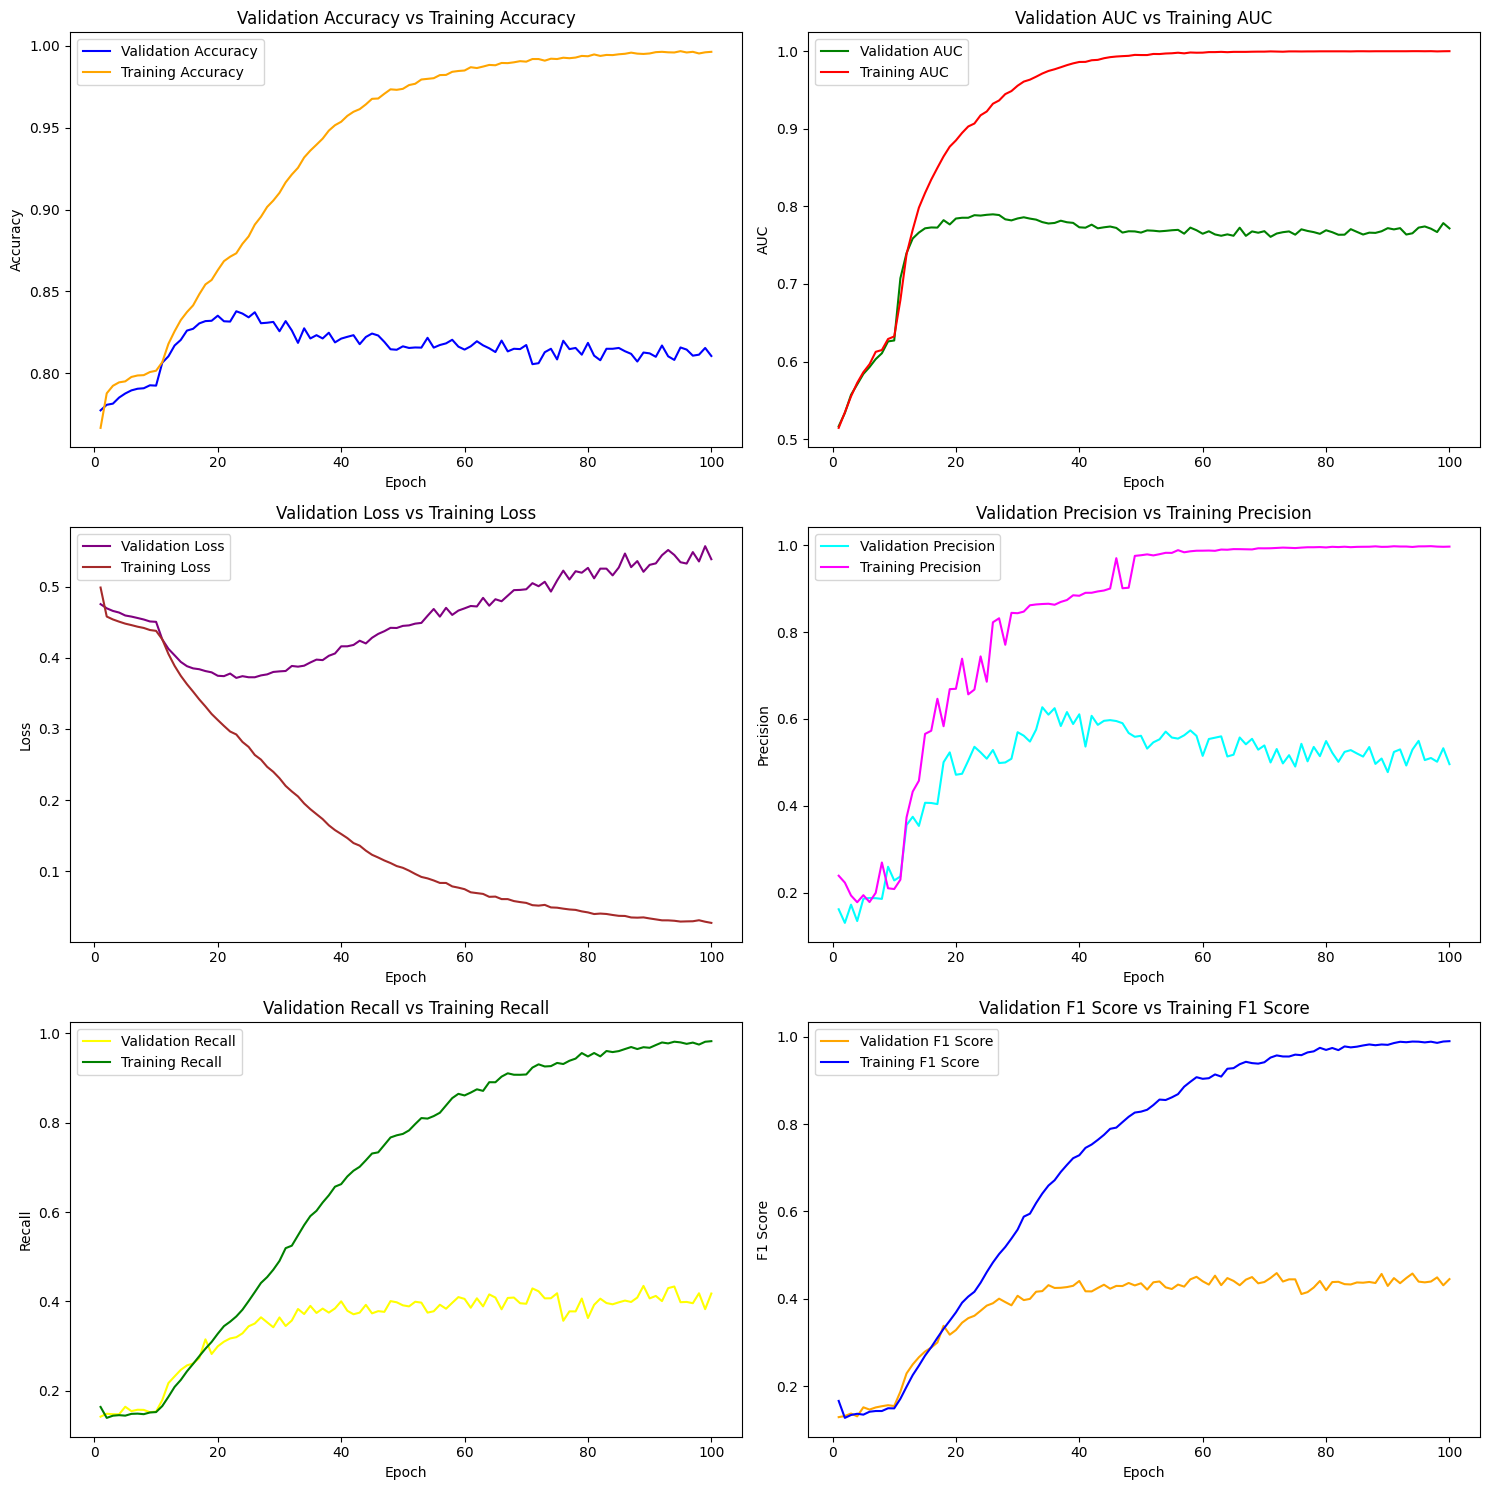

In [31]:
import pandas as pd
import matplotlib.pyplot as plt


# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Plot accuracy
axes[0, 0].plot(history['epoch_number'], history['val_accuracy'], label='Validation Accuracy', color='blue')
axes[0, 0].plot(history['epoch_number'], history['train_accuracy'], label='Training Accuracy', color='orange')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Validation Accuracy vs Training Accuracy')
axes[0, 0].legend()

# Plot AUC
axes[0, 1].plot(history['epoch_number'], history['val_auc'], label='Validation AUC', color='green')
axes[0, 1].plot(history['epoch_number'], history['train_auc'], label='Training AUC', color='red')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('AUC')
axes[0, 1].set_title('Validation AUC vs Training AUC')
axes[0, 1].legend()

# Plot loss
axes[1, 0].plot(history['epoch_number'], history['val_loss'], label='Validation Loss', color='purple')
axes[1, 0].plot(history['epoch_number'], history['train_loss'], label='Training Loss', color='brown')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Validation Loss vs Training Loss')
axes[1, 0].legend()

# Plot precision
axes[1, 1].plot(history['epoch_number'], history['val_precision'], label='Validation Precision', color='cyan')
axes[1, 1].plot(history['epoch_number'], history['train_precision'], label='Training Precision', color='magenta')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Precision')
axes[1, 1].set_title('Validation Precision vs Training Precision')
axes[1, 1].legend()

# Plot recall
axes[2, 0].plot(history['epoch_number'], history['val_recall'], label='Validation Recall', color='yellow')
axes[2, 0].plot(history['epoch_number'], history['train_recall'], label='Training Recall', color='green')
axes[2, 0].set_xlabel('Epoch')
axes[2, 0].set_ylabel('Recall')
axes[2, 0].set_title('Validation Recall vs Training Recall')
axes[2, 0].legend()

# Plot F1 score
axes[2, 1].plot(history['epoch_number'], history['val_f1'], label='Validation F1 Score', color='orange')
axes[2, 1].plot(history['epoch_number'], history['train_f1'], label='Training F1 Score', color='blue')
axes[2, 1].set_xlabel('Epoch')
axes[2, 1].set_ylabel('F1 Score')
axes[2, 1].set_title('Validation F1 Score vs Training F1 Score')
axes[2, 1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [32]:
model_path = '/kaggle/working/best_model_precision.pth'
# model_path = '/kaggle/input/20-03-2024-vinbigdata-multilabel-weights/best_model_auc.pth'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [33]:
test_scores_all = []
test_labels_all = []
test_predictions_all = []

correct_test = 0
total_test = 0


# Don't need to keep track of gradients
with torch.no_grad():
    # Set to evaluation mode
    model.eval()

    start = timer()
    #Test loop
    for batch_data in tqdm(test_loader):
        inputs, labels = batch_data[0].to(device), batch_data[1].float().to(device)  

        outputs = model(inputs)
        outputs = outputs.float()
        labels = labels.float()


        scores = torch.sigmoid(outputs)
        predictions = torch.sigmoid(outputs) > 0.5
        total_test += labels.size(0) * labels.size(1)

        correct_test += (predictions == labels).sum().item()

        test_scores_all.extend(scores.detach().cpu().numpy())
        test_labels_all.extend(labels.cpu().numpy())
        test_predictions_all.extend(predictions.cpu().numpy())

    accuracy_test = correct_test / total_test

    print(f"Accuracy: {accuracy_test:.4f}")
    print("correct:", correct_test, " out of ", total_test)

    test_predictions_all = np.array(test_predictions_all).astype(float)
    test_labels_all = np.array(test_labels_all).astype(float)

    print(classification_report(test_labels_all, test_predictions_all, target_names=diseases)) # adjust the target_names

    cm = multilabel_confusion_matrix(test_predictions_all, test_labels_all)
    # we will use macro-averaging strategy.
    accuracy_arr = []
    precision_arr = []
    recall_arr = []
    f1_arr = []

    for i in range(num_classes):
        print(cm[i])
        print(cm[i].sum())

#         cfm_plot = sn.heatmap(cm[i], annot=False)
         # TP + TN / TP + TN  + FP + FN
        accuracy = (cm[i][0][0]+ cm[i][1][1])/cm[i].sum()

        # TP / TP + FP
        precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])

        # TP / TP + FN
        recall = cm[i][1][1]/(cm[i][0][1]+cm[i][1][1]) # sensitivity
        f1 = (2*precision*recall)/(precision+recall)
        print(disease_labels[i],": ",round(accuracy*100,2),"%") ### disease or disease_labels
        print("Precision: ",round(precision,2))
        print("Recall:", round(recall,2))
        print("F1-Score:", round(f1,2))
        print('==========================================================')


        accuracy_arr.append(accuracy)
        precision_arr.append(precision)
        recall_arr.append(recall)
        f1_arr.append(f1)
    
    accuracy_arr = np.nan_to_num(accuracy_arr, nan=0)
    precision_arr = np.nan_to_num(precision_arr, nan=0)
    recall_arr = np.nan_to_num(recall_arr, nan=0)
    f1_arr = np.nan_to_num(f1_arr, nan=0)
            
    accuracy_arr = np.nan_to_num(accuracy_arr, nan=0)
    precision_arr = np.nan_to_num(precision_arr, nan=0)
    recall_arr = np.nan_to_num(recall_arr, nan=0)
    f1_arr = np.nan_to_num(f1_arr, nan=0)
    
    accuracy_macro_test = round(sum(accuracy_arr) / len(accuracy_arr), 4)
    precision_macro_test = round(sum(precision_arr) / len(precision_arr), 4)
    recall_macro_test = round(sum(recall_arr) / len(recall_arr), 4)
    f1_macro_test = round(sum(f1_arr) / len(f1_arr), 4)
    roc_auc_macro_test = round(roc_auc_score(test_labels_all, test_scores_all, average='macro'), 4)

    print("MACRO-averged metrics", end=':- ')
    print(f"accuracy: {accuracy_macro_test}, precision: {precision_macro_test}", end=', ')
    print(f"recall: {recall_macro_test}, f1: {f1_macro_test}, ROC_AUC: {roc_auc_macro_test}")

    infer_time = timer()-start
    print(f"INFERENCE TIME: {(infer_time):.4f} seconds")
    print("-"*120)

100%|██████████| 55/55 [00:04<00:00, 13.60it/s]


Accuracy: 0.8274
correct: 5097  out of  6160
                    precision    recall  f1-score   support

Aortic enlargement       0.84      0.90      0.87       302
       Atelectasis       1.00      0.05      0.10        19
     Calcification       0.43      0.05      0.09        57
      Cardiomegaly       0.82      0.84      0.83       210
     Consolidation       0.44      0.12      0.19        34
               ILD       0.59      0.25      0.35        40
      Infiltration       0.56      0.32      0.41        68
      Lung Opacity       0.58      0.48      0.53       142
       Nodule/Mass       0.29      0.17      0.22        69
      Other lesion       0.39      0.30      0.34       122
  Pleural effusion       0.71      0.56      0.63       108
Pleural thickening       0.66      0.69      0.67       203
      Pneumothorax       0.00      0.00      0.00        12
Pulmonary fibrosis       0.68      0.58      0.63       183

         micro avg       0.69      0.58      0.63    

/tmp/ipykernel_26/155302291.py:60: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])
